<div style="background-color:rgba(230, 245, 255, 1.0); text-align:center; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 255, 1.0); color: #000000;">

<h1><strong>MIT Quantum Winter School</strong></h1>

<h1><strong>Day 3 - Entanglement</strong></h1>

<img src="figures/course_logo.png" width="500"/>

</div>

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

# Importing standard Qiskit libraries
import qiskit
import qiskit_aer
import pylatexenc
from qiskit import *
from qiskit_aer import *
from qiskit.compiler import transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.quantum_info import Statevector, DensityMatrix, random_statevector, random_density_matrix
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import GroverOperator, MCMT, ZGate

# QWS helpers
from helpers import convert_to_basis_string, get_all_pauli_strings,interactive_sine_waves, double_slit_experiment

# Bokeh interactive plotting
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Slider, ColumnDataSource, CustomJS, Range1d, Toggle, Button, SetValue
from bokeh.layouts import column, row
from bokeh.io import push_notebook
# Initialize the notebook output
output_notebook()

nshots = 10000

Loading BokehJS ...

# Density Matrices (from Day 2)

As we learned in class, another way to represent quantum states besides braket notation is with density matrices.

$$\rho = |\psi\rangle\langle\psi|$$

## Checkpoint



Compute the density matrix for the following one-qubit states:

$$|0\rangle, |1\rangle, |+\rangle, |-\rangle, |+i\rangle, |-i\rangle$$

Optional: Compute the density matrix for the following two-qubit states:

$$\frac{|00\rangle+|11\rangle}{\sqrt{2}}, \frac{|01\rangle+i|11\rangle}{\sqrt{2}}, \frac{|++\rangle+|--\rangle}{\sqrt{2}}$$

Hint: write them as amplitude vectors first.

$$|0\rangle\langle 0| = \begin{pmatrix} 1 & 0 \\ 0 & 0\end{pmatrix}$$
$$|1\rangle\langle 1| = \begin{pmatrix} 0 & 0 \\ 0 & 1\end{pmatrix}$$
$$|+\rangle\langle +| = \frac{1}{2}\begin{pmatrix} 1 & 1 \\ 1 & 1\end{pmatrix}$$
$$|-\rangle\langle -| = \frac{1}{2}\begin{pmatrix} 1 & -1 \\ -1 & 1\end{pmatrix}$$
$$|+i\rangle\langle +i| = \frac{1}{2}\begin{pmatrix} 1 & -i \\ i & 1\end{pmatrix}$$
$$|-i\rangle\langle -i| = \frac{1}{2}\begin{pmatrix} 1 & i \\ -i & 1\end{pmatrix}$$

$$\frac{|00\rangle+|11\rangle}{\sqrt{2}}, \frac{|01\rangle+i|11\rangle}{\sqrt{2}}, \frac{|++\rangle+|--\rangle}{\sqrt{2}}$$


$$\left(\frac{|00\rangle+|11\rangle}{\sqrt{2}}\right)\left(\frac{\langle 00|+\langle 11|}{\sqrt{2}}\right) = \frac{1}{2}\begin{pmatrix} 1 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 1 \end{pmatrix}$$
$$\left(\frac{|01\rangle+i|11\rangle}{\sqrt{2}}\right)\left(\frac{\langle 01|-i\langle 11|}{\sqrt{2}}\right) = \frac{1}{2}\begin{pmatrix} 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & -i \\ 0 & 0 & 0 & 0 \\ 0 & i & 0 & 1 \end{pmatrix}$$
$$\left(\frac{|++\rangle+|--\rangle}{\sqrt{2}}\right)\left(\frac{\langle ++|+\langle --|}{\sqrt{2}}\right) = \frac{1}{4}\begin{pmatrix} 1 & 0 & 0 & 1 \\ 0 & 1 & 1 & 0 \\ 0 & 1 & 1 & 0 \\ 1 & 0 & 0 & 1 \end{pmatrix}$$

## Continuing...

Qiskit gives us a convenient way to visualize density matrices through a variety of commands. For example, let us plot the density matrix for the $|+\rangle$ state ...

<IPython.core.display.Latex object>

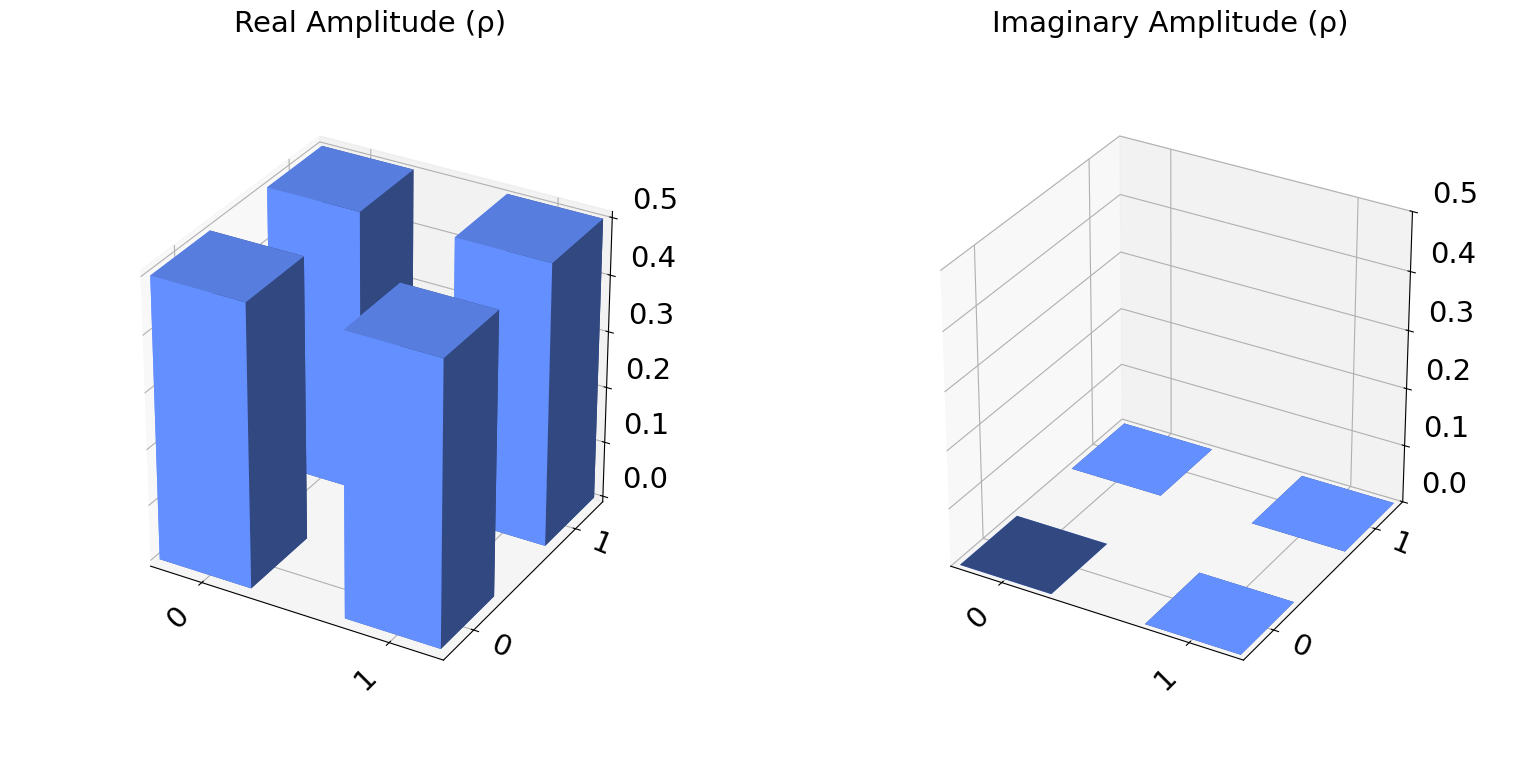

In [3]:
display(Statevector.from_label("+").draw('latex'))
display(Statevector.from_label("+").draw('city'))

... and for the $|-i\rangle$ state.

<IPython.core.display.Latex object>

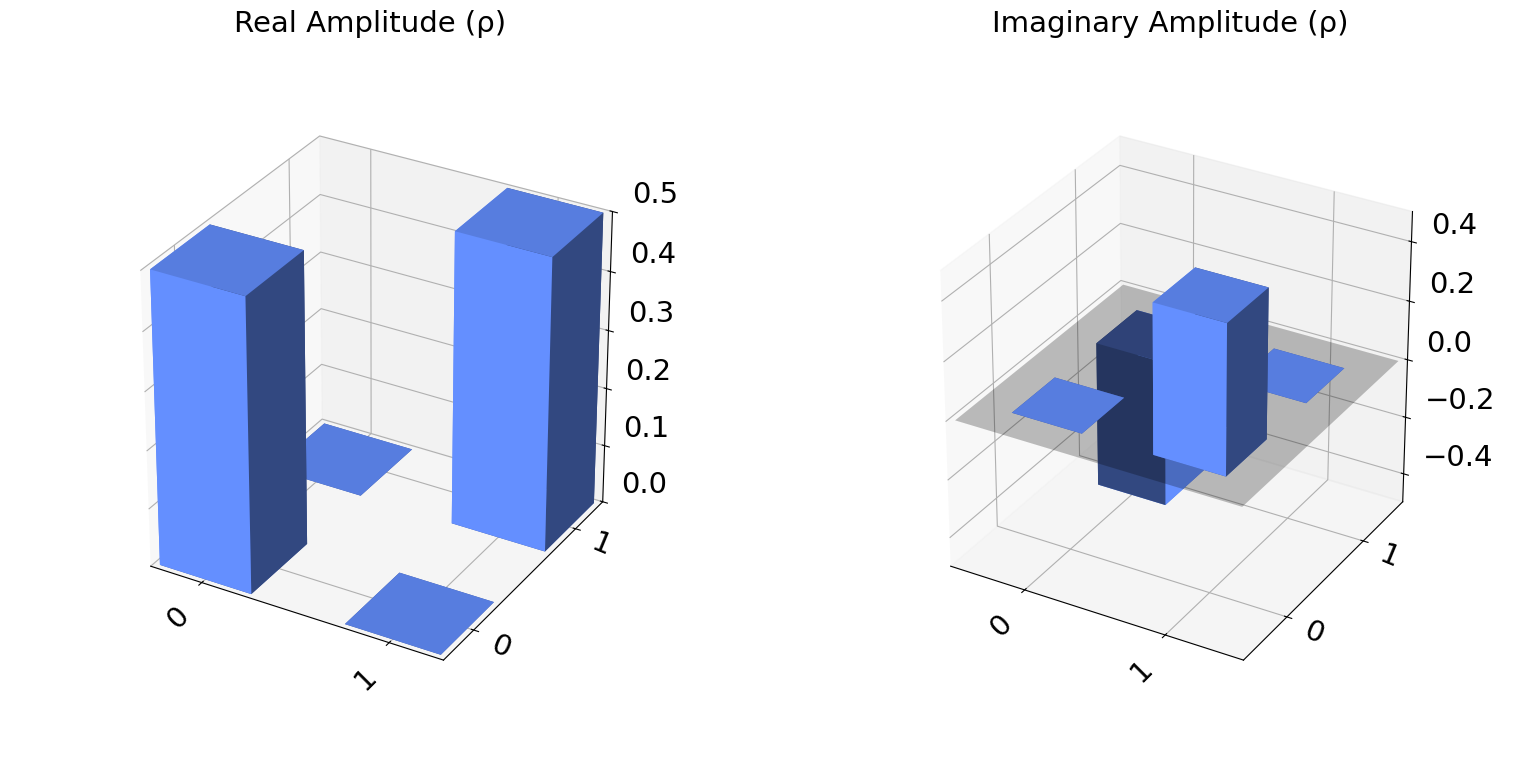

In [4]:
display(Statevector.from_label("l").draw('latex'))
display(Statevector.from_label("l").draw('city'))

As we see above, density matrix elements can take complex values.

For one qubit, the density matrix can be represented as a sum of the Pauli matrices, weighted by the expectation value for each Pauli matrix: $$\rho = \frac{\langle I\rangle I+\langle X\rangle X+\langle Y\rangle Y+\langle Z\rangle Z}{2}.$$

Note that expectation values for Pauli matrices are equivalent to expectation values for measurements in the corresponding basis, according to the scheme that we defined above of assigning a value of (+1) or (-1) to a measurement. Also, $\langle I \rangle = 1$.

We note that this formula for the density matrix contains exactly as much information as the Bloch sphere reconstruction from above. This suggests that reconstructing the density matrix for a state will allow us to learn a sufficient amount of information about the state. Additionally, for systems of more than one qubit, it will be more convenient to stick to density matrices, as there is no convenient Bloch sphere picture that can represent a multiqubit system.

For two qubits, $$\rho = \frac{\langle II\rangle II+\langle IX\rangle IX+\langle IY\rangle IY+\langle IZ\rangle IZ+\langle XI\rangle XI+\langle XX\rangle XX+\langle XY\rangle XY+\langle XZ\rangle XZ+\langle YI\rangle YI+\langle YX\rangle YX+\langle YY\rangle YY+\langle YZ\rangle YZ+\langle ZI\rangle ZI+\langle ZX\rangle ZX+\langle ZY\rangle ZY+\langle ZZ\rangle ZZ}{4},$$

where $\langle XY \rangle$ represents the expectation value of jointly measuring the first qubit in the X basis and the zeroth qubit in the Y basis.

In general, the formula for the density matrix of an n-qubit system is 

$$\rho = \frac{\sum_{P_i\in\{I,X,Y,Z\}^{n}}\langle P_i\rangle P_i}{2^n}.$$

In words, the density matrix is proportional to the sum of all the Pauli strings (products of single-qubit Pauli operators), weighted by the expectation value for each Pauli matrix.

Let's generate the four cardinal states again and randomly permute them.

In [5]:
state1, state2, state3, state4 = random.sample([Statevector.from_label('+'),
                                                Statevector.from_label('-'),
                                                Statevector.from_label('r'),
                                                Statevector.from_label('l')], 4) # randomly permuting the four options

Measuring only in the Z basis is not very useful, as we discussed above. The distributions are identical.

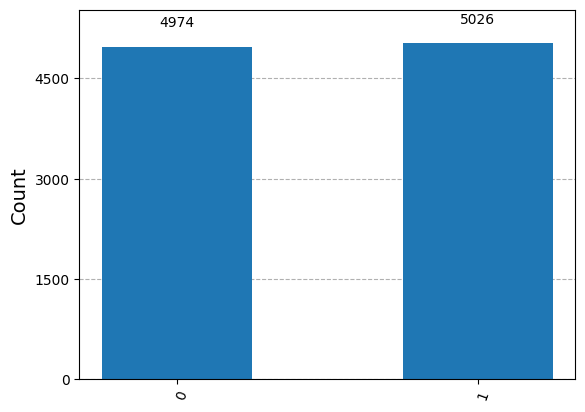

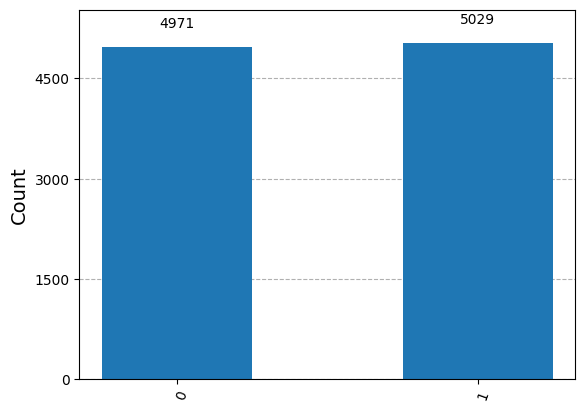

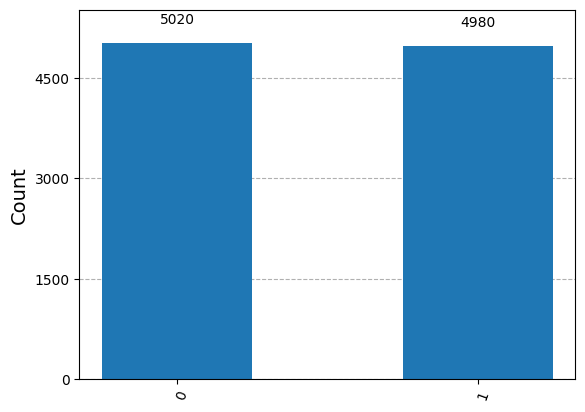

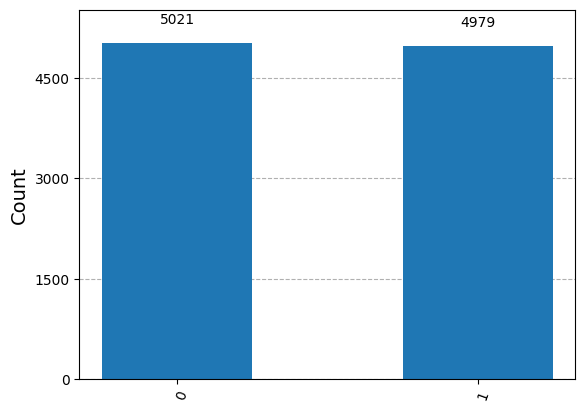

In [6]:
display(plot_histogram(state1.sample_counts(nshots)))
display(plot_histogram(state2.sample_counts(nshots)))
display(plot_histogram(state3.sample_counts(nshots)))
display(plot_histogram(state4.sample_counts(nshots)))

However, their density matrices look different (note the different signs). If we could reconstruct their density matrices, that might be useful for differentiating between the states.

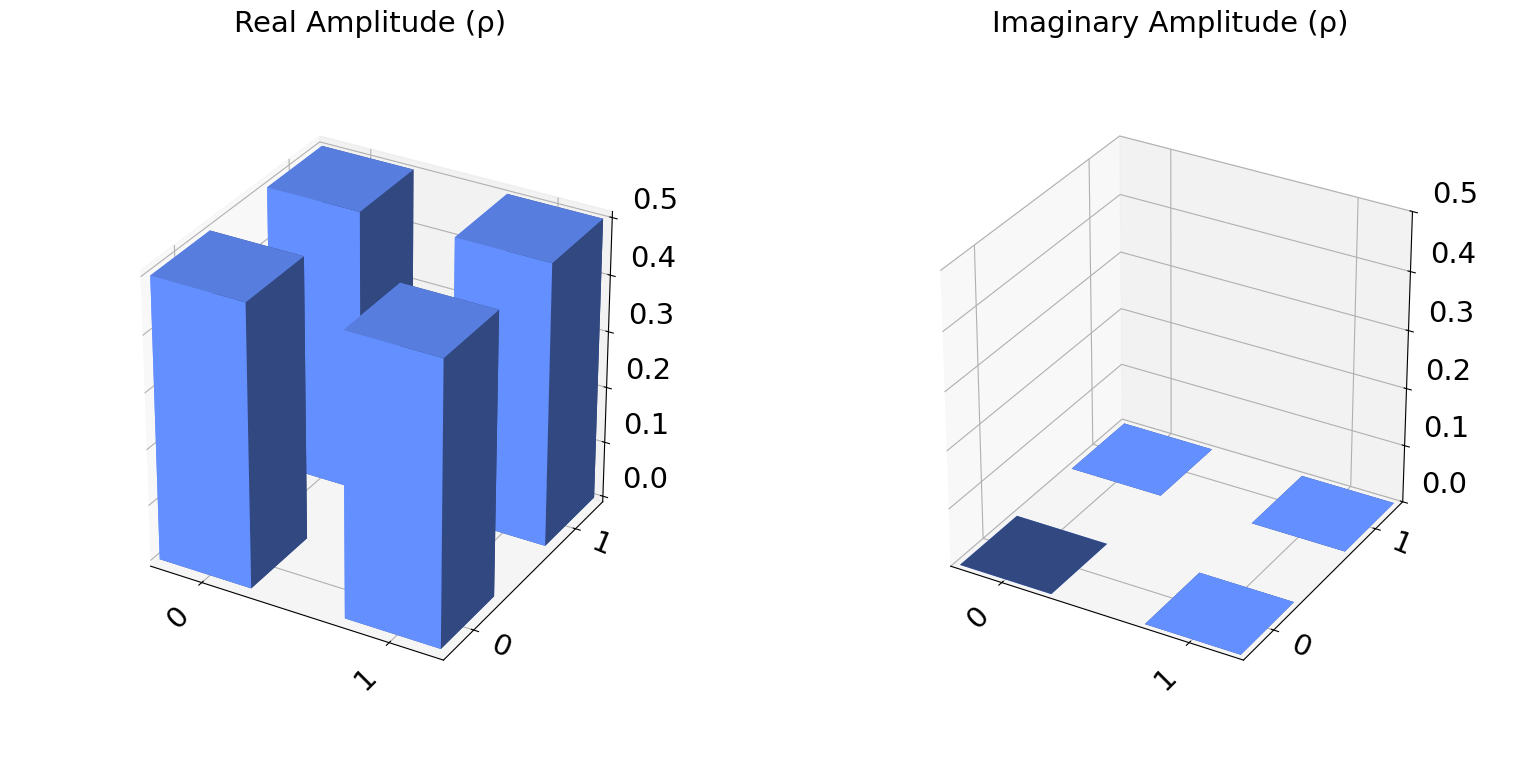

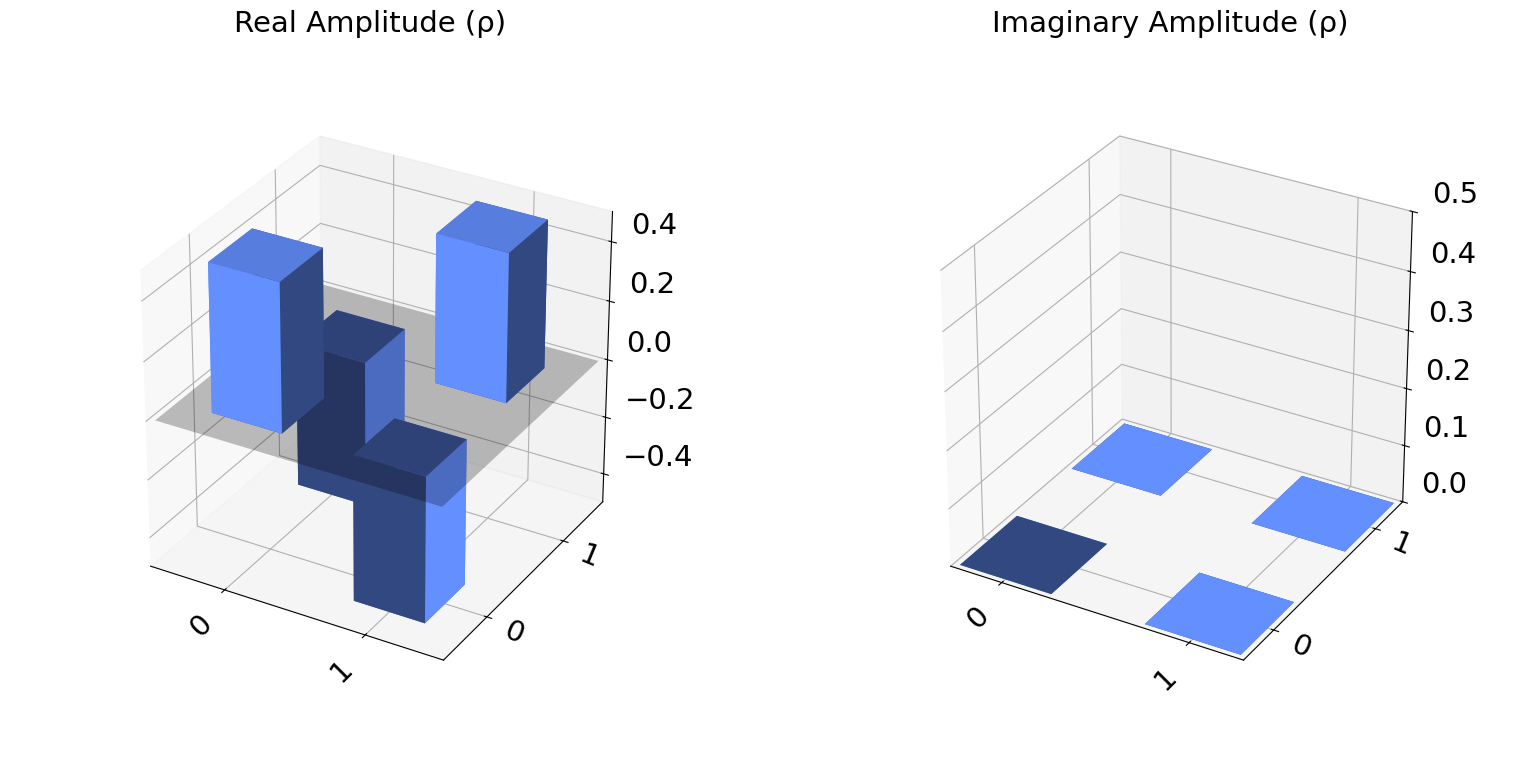

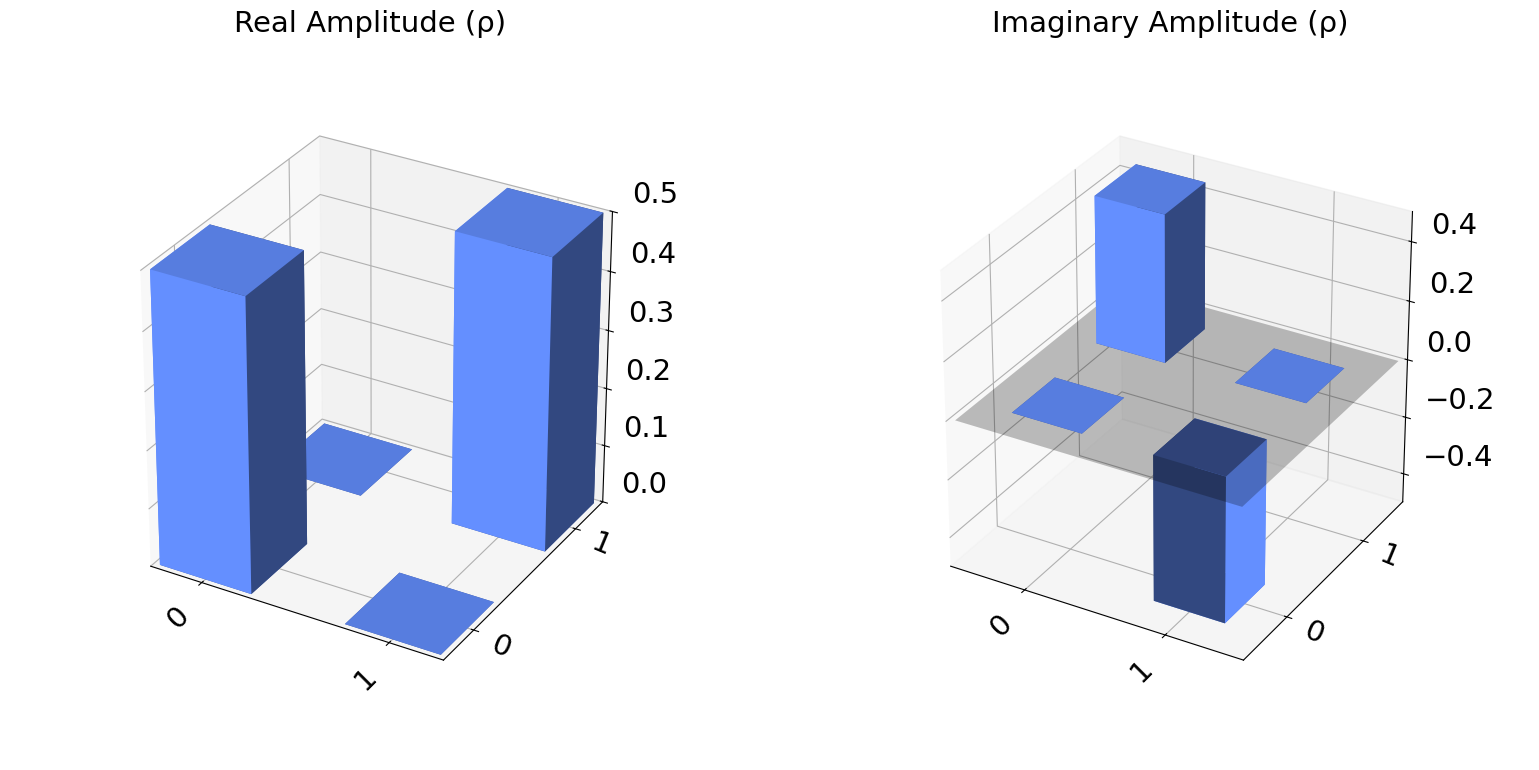

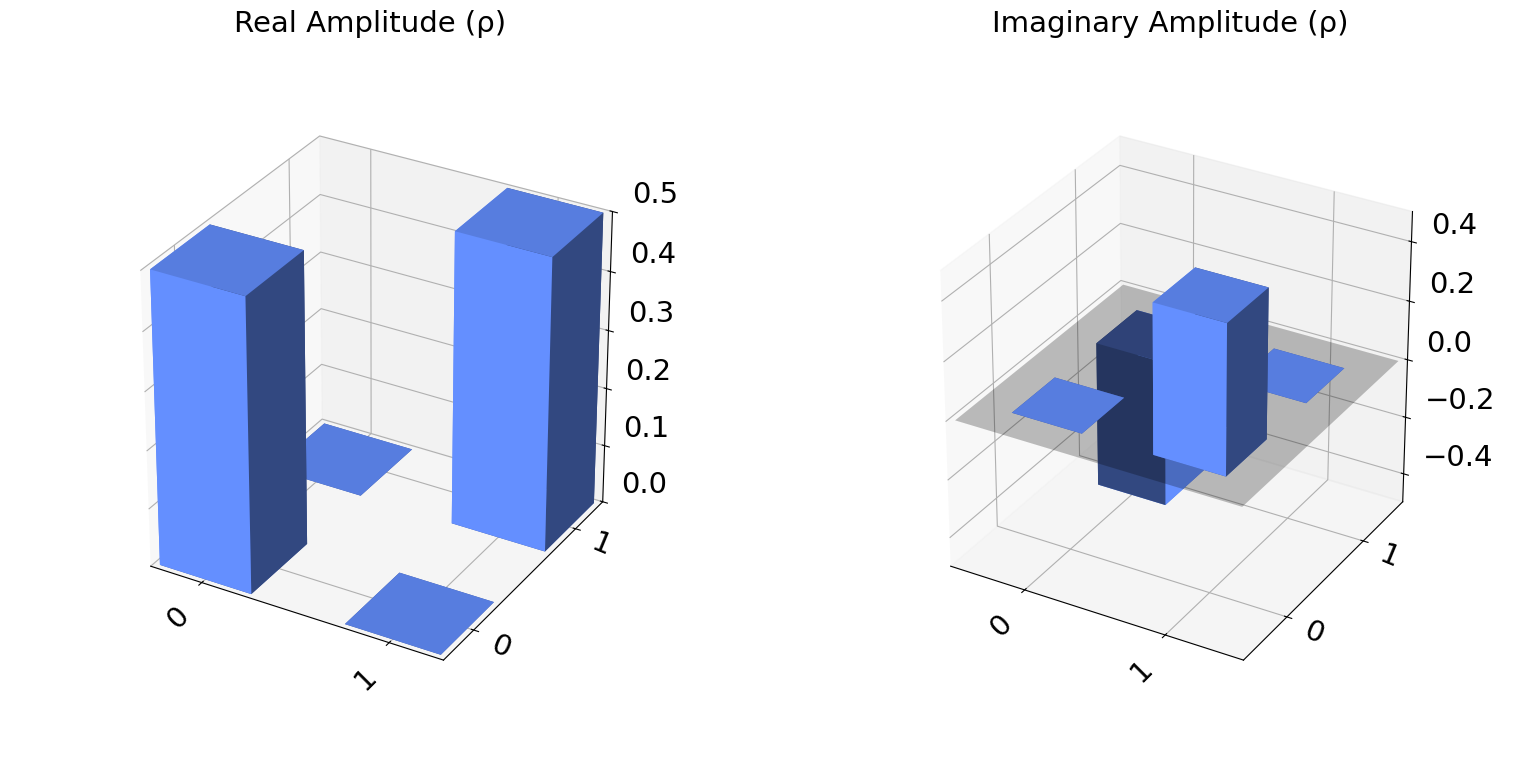

In [7]:
display(state1.draw('city'))
display(state2.draw('city'))
display(state3.draw('city'))
display(state4.draw('city'))

## Checkpoint

Can you match the above four density matrices to the correct states ($|+\rangle, |-\rangle, |+i\rangle, |-i\rangle$)?

In [8]:
display(state1.draw('latex'))
display(state2.draw('latex'))
display(state3.draw('latex'))
display(state4.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Final Notes on Density Matrices

What do all the parts of the density matrix represent?

The diagonal entries represent the probabilities of a measurement ending up in the respective computational state. Consequently, the trace of the density matrix, or the sum of its diagonal entries, will always be $1$, since total probability of the system being measured in some state is always 1.

The off-diagonal entries are known as "coherences" and represent the amount of "quantumness" in the system. We can exactly quantify the "quantumness" through a metric known as the purity, which is computed by taking the trace of the density matrix squared:

$$purity = Tr(\rho^2)$$

Use `density_matrix.purity()` to compute the purity of a density matrix.

The density matrix representation is useful because it also allows us to represent all kinds of states, including pure (quantum) states, fully classical states, and everything in between.

If we prepare the $|+\rangle$ state, a pure state, its density matrix is fully quantum.

**What is the purity of this state?**

On the other hand, if we take the $|+\rangle$ state and now measure it in the Z basis but don't look at the result, there is a 50% chance that it went to each of the $|0\rangle$ and $|1\rangle$ states. The state is no longer in a superposition (we collapsed the superposition when we measured), but it is in a probabilistic mixture of the $0$ and $1$ states. We can describe the new value of the state as $\rho = 0.5|0\rangle\langle 0| + 0.5|1\rangle\langle 1|$. This state is often referred to as the maximally mixed state.

**What is the purity of this state?**

Physical quantum systems are susceptible to error channels that induce loss. The effect is that the system "decoheres" over time. If we were to track the time evolution of the density matrix, we would see the off-diagonal terms shrinking. The purity would be somewhere between the two answers you gave above, trending from the first answer to the second answer as the loss terms entirely dominate and fully decohere the system.

Come talk to the lab staff if you want to learn more about errors!

## Exercises

Plot the density matrix for the maximally mixed state. Notice how the off-diagonal entries are zero! This means it is entirely a classical state, equivalent to a fair coin which has two equiprobable classical outcomes.

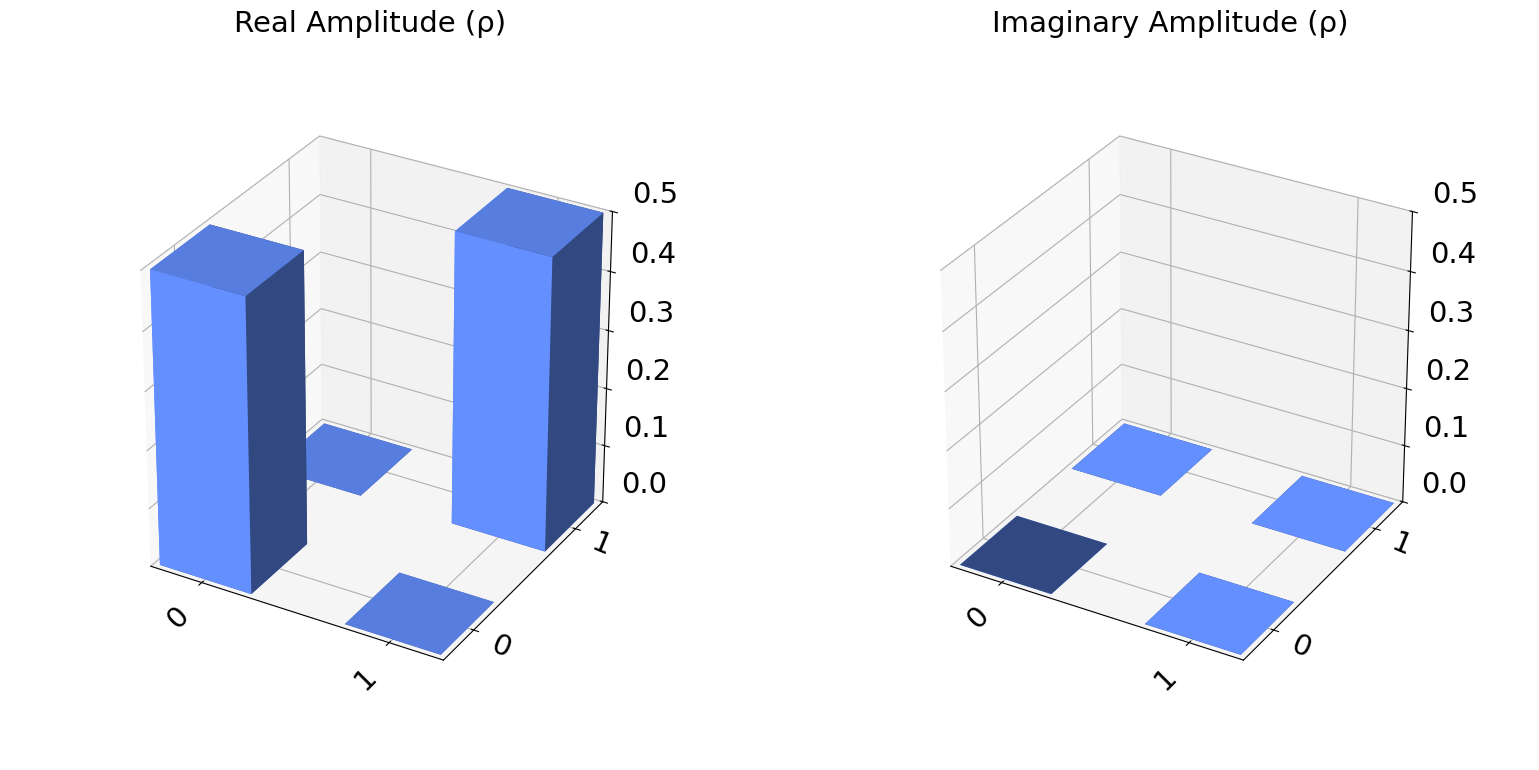

In [9]:
maximally_mixed_state = (DensityMatrix(Statevector.from_int(0,2)) + DensityMatrix(Statevector.from_int(1,2)))/2
display(maximally_mixed_state.draw('city'))

Measure the maximally mixed state in the $X$ basis and compare the result to measuring the $|+\rangle$ state in the X basis. Plot the histograms below.

Hint: you can take `maximally_mixed_state` that you created above and evolve it with `dm = maximally_mixed_state.evolve(qiskit.circuit.library.HGate())` to measure in another basis. Use `dm.sample_counts()` to obtain the counts.

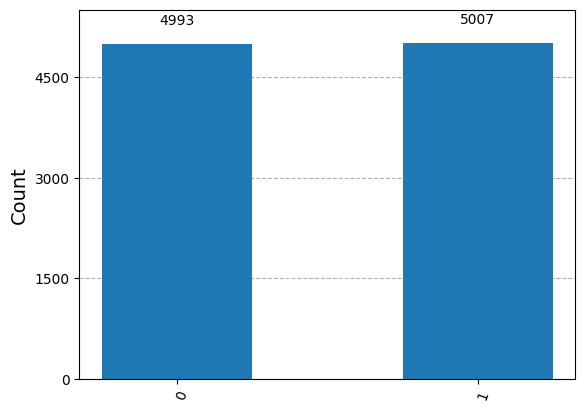

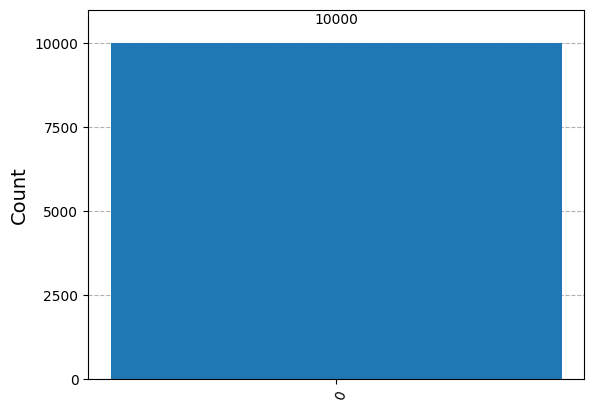

In [10]:
# plot the distribution for the maximally mixed state

maximally_mixed_state = (DensityMatrix(Statevector.from_int(0,2)) + DensityMatrix(Statevector.from_int(1,2)))/2 # generate MMS
counts = maximally_mixed_state.evolve(qiskit.circuit.library.HGate()).sample_counts(nshots) # measure in X basis
display(plot_histogram(counts))

# plot the distribution for the plus state

plus_state = DensityMatrix(Statevector.from_int(0,2).evolve(qiskit.circuit.library.HGate())) # generate plus state
counts = plus_state.evolve(qiskit.circuit.library.HGate()).sample_counts(nshots) # measure in X basis
display(plot_histogram(counts))

### Challenge Problem: Quantum State Tomography with Larger States


Quantum state tomography on larger states entails reconstructing the density matrix for the larger system and follows roughly the same process as above, albeit with far more measurements. For the two-qubit case, we already need to compute sixteen expectation values. Luckily, Qiskit gives us an easy shortcut to compute expectation values for long Pauli strings: `statevector.expectation_value(Pauli(pauli_string))`

Design a protocol to reconstruct the density matrix for a n-qubit state. You may use

```python
qc = QuantumCircuit(n)
qc.initialize(statevector)
```

as many times as you'd like to initialize your circuit with the input state. You may also call `statevector.expectation_value(Pauli(pauli_string))` instead of measuring `nshots` times in the respective basis and computing the expectation value manually. You may not investigate other properties of the `statevector` variable.


Hints:
* We made a function that generates all Pauli strings of length `n` (measurements on n qubits): `get_all_pauli_strings(n)`.
* You should also use `Pauli(pauli_string).to_matrix()`.
* Recall that $$\rho = \frac{\sum_{P_i\in\{I,X,Y,Z\}^{n}}\langle P_i\rangle P_i}{2^n}.$$

In [11]:
# write your protocol
def reconstruct_dm(statevector: Statevector, n):
    # Function to reconstruct the density matrix of an input state
    # Input: statevector: a Qiskit Statevector, n: the number of qubits
    # Output: a (2**n by 2**n) Qiskit DensityMatrix
    
    # starter code
    result = np.zeros((2**n, 2**n), dtype=np.complex128)
    for pauli_string in get_all_pauli_strings(n):
        result += statevector.expectation_value(Pauli(pauli_string))*Pauli(pauli_string).to_matrix()
    return DensityMatrix(result / 2**n)

purity of reconstructed density matrix is (0.9999999999999998+2.5915031623006507e-18j)


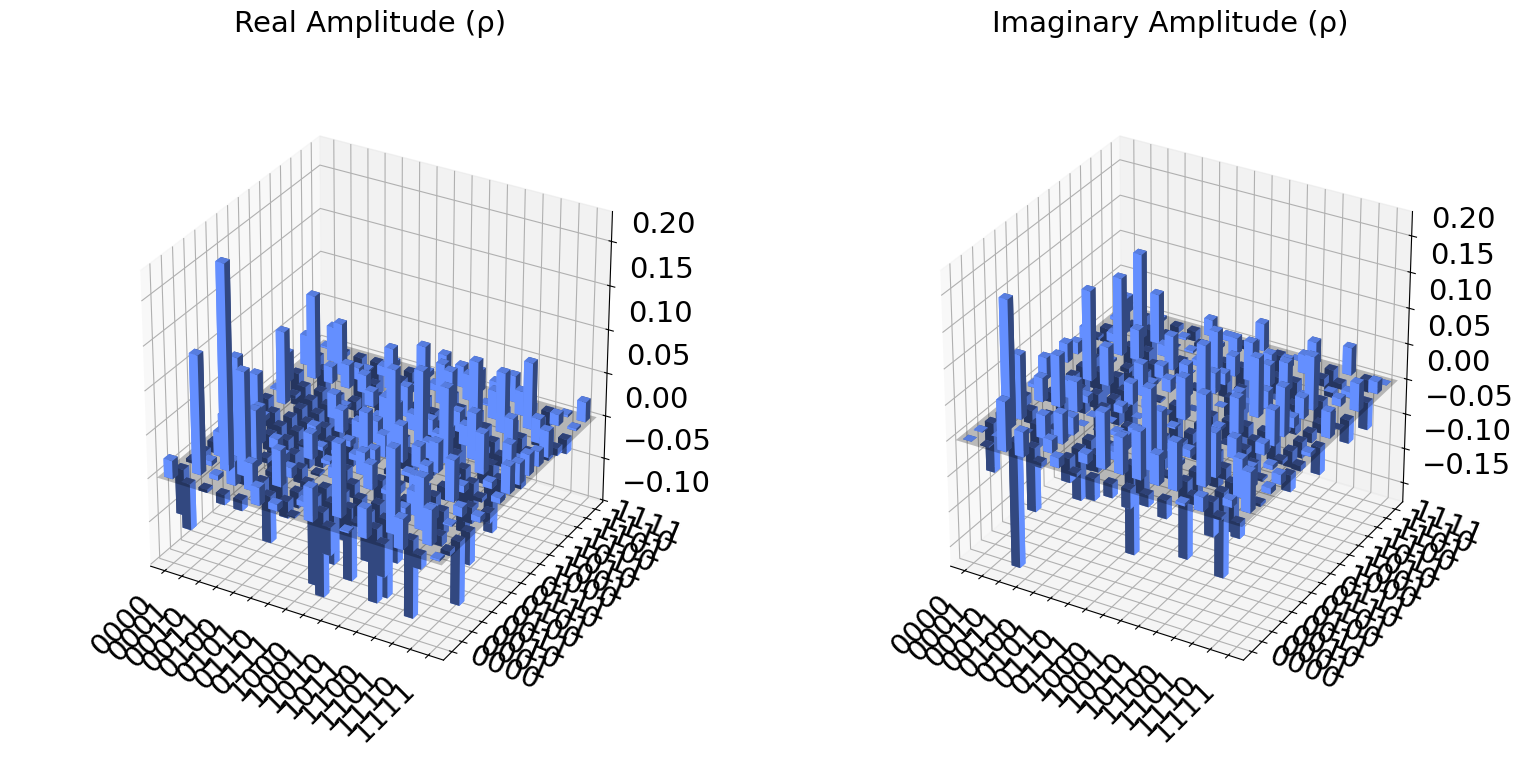

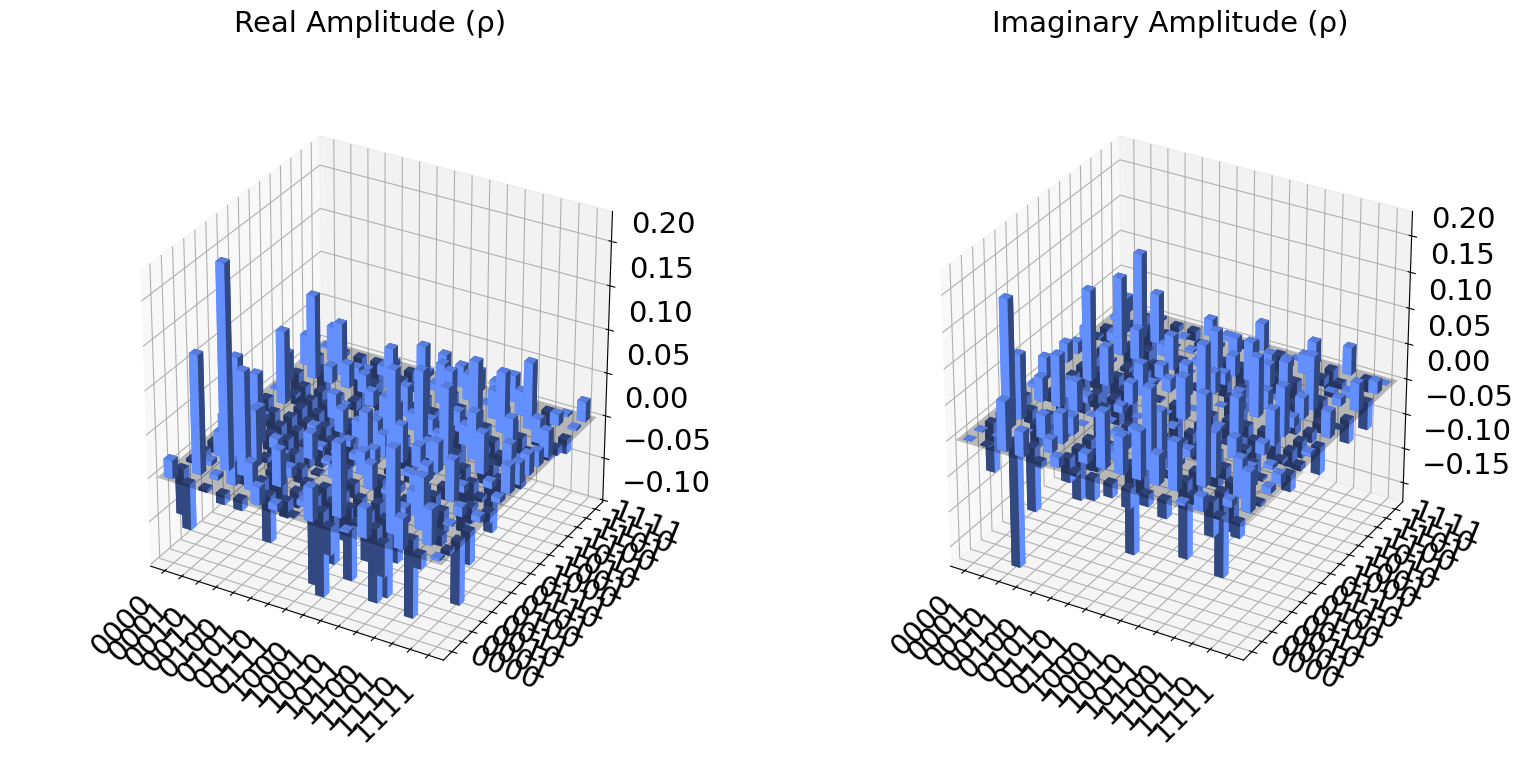

In [12]:
n = 4
statevector = random_statevector(2**n)
density_matrix = reconstruct_dm(statevector, n)
print("purity of reconstructed density matrix is", density_matrix.purity())
display(statevector.draw('city'))
display(density_matrix.draw('city'))

If everything went well, these should be the same.

### Challenge Problem: Recovering a Pure State from a Density Matrix

Let $\rho = |\psi\rangle\langle \psi|$ but we only have $\rho$ or some approximate reconstruction of $\rho$. How do we find $|\psi\rangle$?

Hint: use the spectral decomposition and diagonalize the matrix into its eigenbasis. What do you notice about the relative magnitudes of the eigenvalues?

In [13]:
def recover_state(rho):
    # Function to recover the pure state from a density matrix
    # Input: rho: a Qiskit DensityMatrix, n: the number of qubits
    # Output: a (2**n) unit vector

    eigvl, eigvc = np.linalg.eig(rho)
    result = eigvc[:,np.argmax(np.abs(eigvl))]
    return result/np.exp(1j*np.angle(result[0]))

In [14]:
n = 1

statevector = random_statevector(2**n)
phi = recover_state(DensityMatrix(statevector))
phi_rotated = phi/np.exp(1j*np.angle(phi[0]))*np.exp(1j*np.angle(statevector[0]))
print(statevector)
print(phi)
print(phi_rotated)
print(np.inner(statevector, phi_rotated.conj()))

Statevector([-0.28932912-0.87160749j,  0.38566597+0.08860477j],
            dims=(2,))
[ 0.91837408+0.j         -0.20559484+0.33811212j]
[-0.28932912-0.87160749j  0.38566597+0.08860477j]
(1+5.551115123125783e-17j)


**We can spectrally decompose $\rho$ as a classical mixture of orthogonal pure states: $$\rho = \sum_i p_i |\phi_i\rangle \langle \phi_i |.$$ Up to numerics, only the largest $p_i$ will be nonzero.**

**The eigenvector corresponding to the largest eigenvalue is our best guess for $|\phi\rangle$. This will be equivalent to the initial state up to a global phase.**

### Challenge Problem: Quantum Process Tomography

Suppose we have an unknown quantum circuit whose behavior we want to characterize. The circuit's behavior can be described by a unitary matrix $U$ which we hope to find out.

We can run a similar procedure to quantum state tomography known as quantum process tomography. We will run the quantum circuit with various known quantum states as the input and perform quantum state tomography on each resulting output. Once we know how the quantum circuit operates on this set of states, we know how the quantum circuit will operate on any other pure state.

Design a protocol to reconstruct the unitary matrix for a one-qubit unitary operator. You may create as many quantum circuits as you'd like. You may use `statevector.evolve(u)` but you may not investigate other properties of the `u` variable. Reuse your quantum state tomography and pure state recovery protocols from above. How many times do you need to run quantum state tomography?

Hints:
* To obtain the computational basis vectors, use `statevector = Statevector.from_int(i, 2**n)`.
* You can compute the result of the circuit (as a density matrix) by invoking `output_dm = DensityMatrix(statevector.evolve(u))`. Do not directly access `statevector.evolve(u)` as a statevector.
* To find $|u_i\rangle$ from the reconstructed density matrix $\rho_i \approx |u_i\rangle\langle u_i|$ requires some work, as in the previous challenge problem. Due to the imprecision of this reconstruction process, you will have to find eigenstates $|u_{ik}\rangle$ of $\rho_i$ such that $\rho_i = \sum_k p_k |u_{ik}\rangle\langle u_{ik}|$ where $\sum_k p_k = 1$. If your density matrix reconstruction is well-behaved, one of the $p_k$ will be much larger than the others and the corresponding $|u_{ik}\rangle$ is a good guess for $|u_{i}\rangle$, up to a phase factor.
* Keep an eye out for phase! When you reconstruct $U$ from the $|u_{i}\rangle$, some of the columns might need an extra phase factor in relation to one another. Just sampling the computational basis is insufficient. You can assume that $U_{0,0} \in \mathbb{R}$.

In [15]:
import scipy

def reconstruct_operator(u, n):
    # Function to reconstruct the matrix of a unitary operator
    # Input: u: a Qiskit Operator with u[0,0] real, n: the number of qubits
    # Output: a (2**n by 2**n) unitary matrix

    result = np.zeros((2**n, 2**n), dtype=np.complex128)
    
    # compute each column vector, up to a global phase
    for i in range(2**n):
        statevector = Statevector.from_int(i, 2**n)
        output_dm = DensityMatrix(statevector.evolve(u))
        result[:,i] = recover_state(output_dm) # strips the relative phase

    # now we need to compute the relative phase
    # we fix the relative phase of U|0> at zero and determine the remaining relative phases
    # by passing superpositions of |0> and |i> through U and solving
    # for the equal-magnitude linear combination a*(U|0>) + b*(U|i>)
    # then if we rotate a to 0, the relative phase of U|i> is b/a 
    for i in range(1, 2**n):
        statevector = (Statevector.from_int(0,2**n)+Statevector.from_int(i,2**n))/np.sqrt(2)
        output_dm = DensityMatrix(statevector.evolve(u))
        recover = recover_state(output_dm) # removes the global phase
        # recover = (a*result[:,0]+b*result[:,i])/np.sqrt(2) where a, b are unit complex numbers
        # now we need to recover the relative phase between the states
        (a,b), residues, rank, singular_vals = np.linalg.lstsq(result[:,[0,i]], recover)
        # b/a should be the relative phase we need
        result[:,i] *= b/a
        
    return result

In [16]:
n = 1
(Statevector.from_int(0,2**n)+Statevector.from_int(1,2**n))/np.sqrt(2)
u_global_phase = qiskit.quantum_info.random_unitary(2**n)
u = u_global_phase/np.exp(1j*np.angle(u_global_phase.to_matrix()[0,0]))
operator = reconstruct_operator(u, n)
print(np.allclose(u.to_matrix(), operator))
print(u.to_matrix())
print(operator)

True
[[ 0.90822085+1.61612702e-16j  0.17073611+3.82078614e-01j]
 [-0.22441316-3.53233092e-01j -0.50119749+7.57407544e-01j]]
[[ 0.90822085+0.j          0.17073611+0.38207861j]
 [-0.22441316-0.35323309j -0.50119749+0.75740754j]]


Can you use your algorithm on a larger system? How many times do you need to run quantum state tomography?

In [17]:
n = 3
u_global_phase = qiskit.quantum_info.random_unitary(2**n)
u = u_global_phase/np.exp(1j*np.angle(u_global_phase.to_matrix()[0,0]))
operator = reconstruct_operator(u, n)
print(np.allclose(u.to_matrix(), operator))
print(u.to_matrix())
print(operator)
print()
for i in range(2**n):
    print(np.abs(u.to_matrix()[:,i]))
    print(np.abs(operator[:,i]))

True
[[ 0.36452174+6.86441122e-19j  0.07351982+3.68908917e-01j
  -0.28149133-2.51602723e-01j -0.02646494+1.03511609e-01j
  -0.4918575 -1.43059611e-01j -0.1972049 -1.36072206e-01j
   0.19840841-1.33572406e-01j  0.43255203-8.69746696e-02j]
 [-0.39602959+7.19973890e-02j  0.34388195-3.13306143e-01j
  -0.063975  -2.22173113e-01j -0.57244016+2.84676304e-01j
  -0.15554406-2.27488237e-01j  0.07883342+2.42477938e-01j
  -0.01361049-7.61477722e-02j  0.10247562-4.40372997e-02j]
 [ 0.17962877+1.42766740e-01j -0.23494819-1.28729238e-01j
   0.17162482+3.13454036e-01j -0.15135915+2.40601131e-02j
   0.12687866+1.20803167e-01j -0.25303722+5.30827017e-01j
   0.27833496+2.52480743e-01j  0.44274511-1.03176719e-01j]
 [-0.12925951-2.64981014e-01j  0.03574761+6.36789810e-02j
  -0.22273804+5.18669427e-01j -0.02769038+6.96548756e-02j
   0.08357524-5.86363375e-02j  0.47560023-1.36682506e-01j
   0.11787193-1.54833891e-01j  0.40579639+3.54480753e-01j]
 [-0.11726056-4.48949911e-01j -0.20736382-2.56213132e-01j
   0.

# Sending Quantum States

## Introduction

Suppose Alice has an arbitary one-qubit quantum state.

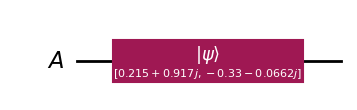

In [18]:
a = QuantumRegister(1, name="A")
qc = QuantumCircuit(a)
state = random_statevector(2)
qc.initialize(state, [0])

display(qc.draw('mpl'))

Alice wants to send Bob this state, perhaps as part of some protocol related to quantum communication. How can they do this?

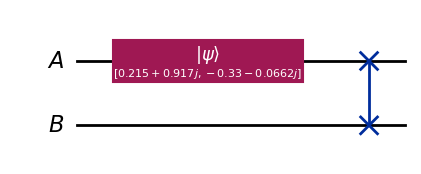

In [19]:
a = QuantumRegister(1, name="A")
b = QuantumRegister(1, name="B")
qc = QuantumCircuit(a, b)
qc.initialize(state, [0])
qc.swap(0,1)

display(qc.draw('mpl'))

Alice and Bob can perform the SWAP gate to swap their qubits. Note that Alice no longer has access to her state (this would be prohibited by the no-cloning theorem).


However, this protocol requires Alice and Bob to be able to perform a joint two-qubit gate. If Alice and Bob are spatially separated or otherwise unable to perform a joint two-qubit gate, this would be impossible. What can they do instead?

## Quantum State Teleportation

Quantum state teleportation is an elementary protocol in quantum computing that allows one party to send another a quantum state. All it requires is that the parties share a Bell pair (maximally entangled state) and that the sender can locally perform two-qubit gates and send the recipient classical information (such as measurement results).

<div style="background-color:rgba(243, 248, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(101, 174, 247, 1.0); color: #000000;">

<h4><strong>The Math Behind Quantum Teleportation</strong></h4>

Although the name is suggestive of object transfer, it is a bit misleading. Perhaps a more precise name would be quantum \textit{information} teleportation. The protocol is as follows:

1. Alice and Bob each receive one qubit of a Bell pair. 
2. Alice wants to transfer a qubit $\ket{\phi}_A=\alpha\ket{0}+\beta\ket{1}$ to Bob, perhaps over a great spatial distance. In other words, Bob should end up with qubit
    $$
        \ket{\phi}_B=\alpha\ket{0}+\beta\ket{1} \nonumber
    $$
    that can be manipulated, measured, etc. in the same way as Alice's qubit $\ket{\phi}_A$.
3. Because Alice has two qubits, they can perform a *Bell measurement* on them, as if one were trying to determine which of the four Bell states the two Alice qubits are in.
4. Half of the time, this turns out to send Bob's qubit into a superposition that, within a local phase flip, looks like $\ket{\phi}_A$:
    $$
        \ket{\phi}_B=\alpha\ket{0}\pm\beta\ket{1} \nonumber
    $$
    Thus, Bob can apply a Z gate if needed to bring $\ket{\phi}_B$ to the desired superposition. What about the other half of the time? The result is a little more complicated
    $$
        \ket{\phi}_B=\alpha\ket{1}\pm\beta\ket{0} \nonumber
    $$
    but it can be seen that with judicious application of an additional bit-flip (X gate), this becomes identical to the previous case requiring a local phase flip.
5. How does Bob know whether or not to apply an X or Z gate or both? It turns out that the bit-flip and relative phase depends on which of the four Bell states Alice measured. Thus, Alice also needs to transfer two *classical* bits, corresponding to the measurement results from Step 3. 

The circuit for the procotol can be expressed as:

<img src="figures/entanglement/quantum_tele_circuit.png" width="800"/>

Of course, one could conceive of simply sending a $\ket{\phi}$ encoded photon to Bob. The key is that with quantum teleportation, Alice never even has to do that! Remember, the Bell pair could be coming from someone else entirely, a third party. Instead, Alice only ever needs to transmit classical information to Bob (which unfortunately, does limit the communication to the speed of light).

It might seem like this protocol appears out of nowhere. The key intuition here is that _the four Bell states form a complete basis for a two-qubit composite system._ Thus, even though Alice's qubits may not be in a maximally-entangled state, they can always be decomposed into a superposition of Bell states. Roughly speaking, this suggests the full Alice-Bob three-qubit composite system may be able to be factorized as a tensor product of the Alice Bell-state decomposition, times Bob's qubit, with weights related to $\ket{\phi}_A$. Measurement then projects Bob's qubit into the desired state.

Suppose the shared entangled state between Alice and Bob is the Bell state $\ket{\Phi^+}$. Then the full composite system is given by:
$$\begin{equation}
    \ket{\phi}_A \ket{\Phi^+}_{AB} = \frac{1}{\sqrt{2}}(\alpha\ket{0}_A\pm\beta\ket{1}_A)(\ket{0}_A\ket{0}_B+\ket{1}_A\ket{1}_B)
\end{equation}$$
where the subscripts indicate whom the qubits belong to. Then, decomposing Alice's qubits in the Bell basis, we obtain
$$\begin{align}
    \ket{\phi}_A \ket{\Phi^+}_{AB} = \frac{1}{2}[&\ket{\Phi^+}_A(\alpha\ket{0}_B+\beta\ket{1}_B) \nonumber \\ + &\ket{\Phi^-}_A(\alpha\ket{0}_B-\beta\ket{1}_B) \nonumber \\ + &\ket{\Psi^+}_A(\alpha\ket{1}_B+\beta\ket{0}_B) \nonumber \\ + &\ket{\Psi^-}_A(\alpha\ket{1}_B-\beta\ket{0}_B)]
\end{align}$$
In both a mathematical and physical sense, the probability amplitudes of $\ket{\phi}_A$ "transfer over" to Bob's qubit. It is clear then that each Bell state is associated with a particular Bob qubit state that needs to be communicated to ensure the proper phase relation between $\ket{0}_B$ and $\ket{1}_B$. 

We summarize the four possible Bell state measurement results for Alice and Bob's required manipulations in the following table:

| Alice's Result &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Bob's state &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Bob's state (in terms of $\ket{\phi}$) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Bob applies &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- |
 |$\ket{\Phi^+} ~~~ (00)$ | $\alpha \ket{0} + \beta \ket{1} $ | $\ket{\psi}$ | $\mathbb{1}$ |
 |$\ket{\Psi^+} ~~ (01)$ | $\alpha \ket{1} + \beta \ket{0} $ | $X\ket{\psi}$ | $X$ | 
 |$\ket{\Phi^-} ~~ (10)$ | $\alpha \ket{0} - \beta \ket{1} $ | $Z\ket{\psi}$ | $Z$ |
 |$\ket{\Psi^-} ~~ (11)$ | $\alpha \ket{1} - \beta \ket{0} $ | $XZ\ket{\psi}$ | $ZX$ |

</div>

## Exercises

### Implement Teleportation

Implement the rest of the quantum state teleportation protocol. Assume $A_0$ is an arbitrary state.

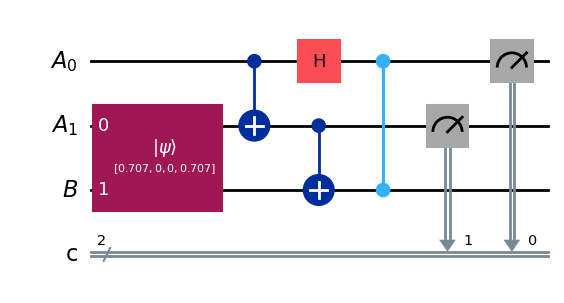

In [20]:
a = QuantumRegister(2, name="A")
b = QuantumRegister(1, name="B")
c = ClassicalRegister(2, name="c")
qc = QuantumCircuit(a, b, c)
qc.initialize(Statevector([1/np.sqrt(2),0,0,1/np.sqrt(2)]), [1,2]) # initializes a Bell pair between A&B
qc.cx(0,1)
qc.h(0)
qc.cx(1,2)
qc.cz(0,2)
qc.measure([0,1],[0,1])
display(qc.draw('mpl'))
teleportation = qc.to_instruction(label="Teleport")

### Algebraic Verification

Algebraically show that your protocol works.

**See the blue box above.**

### Experimental Verification

Experimentally verify that $B$ contains the state initialized in $A_0$ after the teleportation protocol. You can assume that you know the statevector coefficients of $A_0$ -- perhaps Alice told you. You may call `qc = prepare(state)` an infinite number of times, but you are only allowed to perform gates on and measure $B$.

Hint: refer to the techniques we explored yesterday.

In [21]:
def prepare(state):
    a = QuantumRegister(2, name="A")
    b = QuantumRegister(1, name="B")
    c = ClassicalRegister(3, name="c")
    qc = QuantumCircuit(a, b, c)
    qc.initialize(state, [0], normalize=True)
    qc.append(teleportation, [0,1,2],[0,1])
    return qc

state_rotated = random_statevector(2)
state = state_rotated/np.exp(1j*np.angle(state_rotated[0]))

# Z basis
qc = prepare(state)
qc.measure(2,2)
backend = Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit, shots = nshots)
results = job.result()
z_counts = results.get_counts()

# X basis
qc = prepare(state)
qc.h(2)
qc.measure(2,2)
backend = Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit, shots = nshots)
results = job.result()
x_counts = results.get_counts()

# Y basis
qc = prepare(state)
qc.sdg(2)
qc.h(2)
qc.measure(2,2)
backend = Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit, shots = nshots)
results = job.result()
y_counts = results.get_counts()

sx = (sum(x_counts[i] for i in x_counts if i[0] == '0')-sum(x_counts[i] for i in x_counts if i[0] == '1'))/nshots
sy = (sum(y_counts[i] for i in x_counts if i[0] == '0')-sum(y_counts[i] for i in x_counts if i[0] == '1'))/nshots
sz = (sum(z_counts[i] for i in x_counts if i[0] == '0')-sum(z_counts[i] for i in x_counts if i[0] == '1'))/nshots

theta = np.arccos(sz)
phi = np.atan2(sy, sx)

psi = Statevector([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)])
print(psi)
print(state)

Statevector([0.97390965+0.j        , 0.12738687-0.18780997j],
            dims=(2,))
Statevector([0.97403289-1.52605503e-17j, 0.13225387-1.83762988e-01j],
            dims=(2,))


**We perform state tomography to verify we have the correct output state.**

# Entanglement and Partial Measurement

We now take a brief diversion to talk about entanglement and partial measurement.

## Partial trace

We often prepare a multi-qubit states. Suppose we measure one of the qubits but don't look at the result. What is the state of the rest of the system, comprising the remaining qubits that we didn't measure?

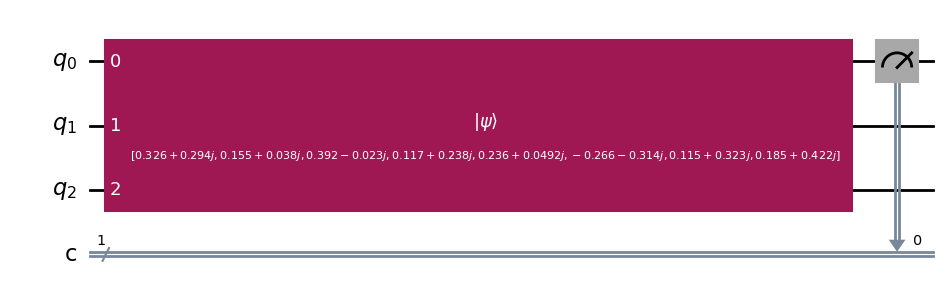

In [22]:
random_state = random_statevector(8)
qc = QuantumCircuit(3, 1)
qc.initialize(random_state)
qc.measure(0, 0)
display(qc.draw('mpl'))

Since the remaining state is conditioned on the result of the measurement, and the measurement is probabilistic, it might make sense to describe the remaining state as a probabilistic mixture as well. The most suitable representation for this is the density matrix.

## Entanglement entropy

Entanglement entropy is a way to quantify how much entanglement there is between two subsystems of a larger quantum system. Two systems that are entirely unentangled (product states) have zero entanglement entropy; as the name suggests, the maximally entangled state has the highest possible entanglement entropy for a state of that size.

## Exercises

### Calculate the entanglement entropy

The entanglement entropy for a subsystem $\rho_A$ is given by $-Tr(\rho_A\ln\rho_A)$.

In [23]:
def entropy(rho):
    eigvals = np.linalg.eigvals(rho)
    return np.abs(sum(eigvals*np.where(eigvals==0,0,np.log2(eigvals))))

Verify that your result matches `qiskit.quantum_info.entropy`.

In [24]:
dm = DensityMatrix(random_statevector(4))
reduced = qiskit.quantum_info.partial_trace(dm, [0])
print(entropy(reduced), qiskit.quantum_info.entropy(reduced))

0.0745656959160029 0.0745656959160029


### Challenge Problem: Schmidt decomposition

Investigate the Schmidt decomposition of a vector. Determine how this can be useful for determining the entanglement entropy of a system.

**For a given composite system comprising two subsystems A and B, you can find corresponding orthogonal bases $\left\{|\phi_i\rangle_A,...\right\}$ and $\left\{|\phi_i\rangle_B,...\right\}$ for A and B respectively, such that $|\psi\rangle$ can be represented as a superposition of product states between the two subsystems: $$|\psi\rangle = \sum_i \lambda_i|\phi_i\rangle_A|\phi_i\rangle_B.$$ Then you can compute the entanglement entropy between A and B by simply computing $-\sum_i \lambda_i \log_2 \lambda_i$.**


# Entanglement Swapping

In a similar vein to the teleportation protocol, sometimes we wish to distribute entanglement between two parties that are separated. We can make use of a protocol known as entanglement swapping. All it requires is that the parties each share a Bell pair (maximally entangled state) with a mutual intermediary and that the intermediary can generate additional Bell pairs and participate in any other quantum protocols.

## Exercises

### Implement Entanglement Swapping

Implement the entanglement swapping protocol.

Hint: if qubits `y` and `z` are entangled and qubits `x` and `y` belong to the same party, `qc.append(teleportation, [x, y, z])` will send the state in qubit `x` to `z`.

/Users/om/EQuS/qws-labs/qws-lab-venv/lib/python3.13/site-packages/qiskit/circuit/quantumcircuit.py:3440: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


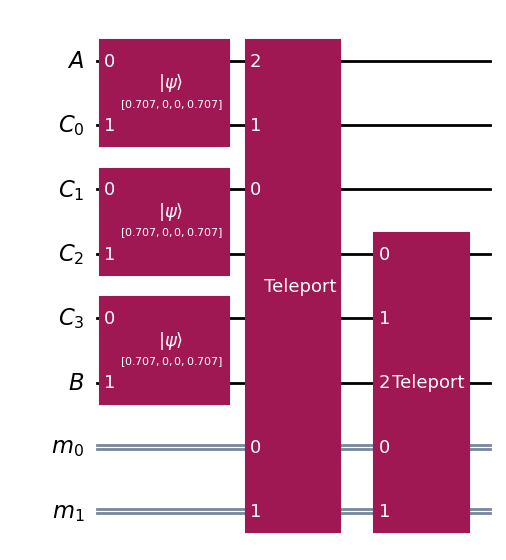

In [25]:
def prepare():
    a = QuantumRegister(1, name="A")
    c = QuantumRegister(4, name="C")
    b = QuantumRegister(1, name="B")
    cr = ClassicalRegister(2, name='m')
    
    # quantum circuit combines quantum and classical registers
    qc = QuantumCircuit(a, c, b, cr)
    qc.initialize(Statevector([1/np.sqrt(2),0,0,1/np.sqrt(2)]), [0,1])
    qc.initialize(Statevector([1/np.sqrt(2),0,0,1/np.sqrt(2)]), [2,3])
    qc.initialize(Statevector([1/np.sqrt(2),0,0,1/np.sqrt(2)]), [4,5])
    qc.append(teleportation, [2, 1, 0], [0, 1])
    qc.append(teleportation, [3, 4, 5], [0, 1])
    return qc

qc = prepare()
qc.draw('mpl')

### Mathematical Verification

Verify that $A$ and $B$ are maximally entangled by computing their entanglement entropy.

In [26]:
result = np.zeros((4,4), dtype=np.complex128)
for pauli_string in get_all_pauli_strings(2):
    qc = prepare()
    if "I" in pauli_string:
        if pauli_string == "II":
            result += np.identity(4)
            continue
        elif pauli_string[1] == 'I':
            if pauli_string[0] == 'X':
                qc.h(0)
            elif pauli_string[0] == 'Y':
                qc.sdg(0)
                qc.h(0)
            qc.measure(0,0)
            qc.measure(0,1)
        else:
            if pauli_string[1] == 'X':
                qc.h(5)
            elif pauli_string[1] == 'Y':
                qc.sdg(5)
                qc.h(5)
            qc.measure(5,0)
            qc.measure(5,1)
        backend = Aer.get_backend('qasm_simulator')
        new_circuit = transpile(qc, backend)
        job = backend.run(new_circuit, shots = nshots)
        results = job.result()
        counts = results.get_counts()
        exp = (counts.get('00',0)-counts.get('11',0))/nshots
        result += exp * Pauli(pauli_string).to_matrix()
        continue
    if pauli_string[0] == 'X':
        qc.h(0)
    elif pauli_string[0] == 'Y':
        qc.sdg(0)
        qc.h(0)
    if pauli_string[1] == 'X':
        qc.h(5)
    elif pauli_string[1] == 'Y':
        qc.sdg(5)
        qc.h(5)
    
    qc.measure([0,5],[0,1])
    backend = Aer.get_backend('qasm_simulator')
    new_circuit = transpile(qc, backend)
    job = backend.run(new_circuit, shots = nshots)
    results = job.result()
    counts = results.get_counts()
    exp = (sum(counts[i] for i in counts if i[0] == i[1])-sum(counts[i] for i in counts if i[0] != i[1]))/nshots
    result += exp * Pauli(pauli_string).to_matrix()

dm = DensityMatrix(result / 2**(n-1))
print(dm)

reduced = qiskit.quantum_info.partial_trace(dm, [0])

DensityMatrix([[ 4.98e-01+0.j    , -4.00e-04-0.0002j,  1.90e-03+0.0018j,
                 5.00e-01-0.0008j],
               [-4.00e-04+0.0002j,  2.40e-03+0.j    ,  0.00e+00-0.0034j,
                -3.40e-03+0.0012j],
               [ 1.90e-03-0.0018j,  0.00e+00+0.0034j, -2.40e-03+0.j    ,
                 3.50e-03-0.0029j],
               [ 5.00e-01+0.0008j, -3.40e-03-0.0012j,  3.50e-03+0.0029j,
                 5.02e-01+0.j    ]],
              dims=(2, 2))


In [27]:
entropy(qiskit.quantum_info.partial_trace(dm, [1]))

np.float64(0.9998886787873604)

# CHSH Game 

The CHSH game is a thought experiment to investigate certain theories about quantum mechanics.

## About the game

The game is played cooperatively by two parties, Alice and Bob, and moderated by a host, Charlie.

Charlie generates two bits $x$ and $y$ and sends $x$ to Alice and $y$ to Bob. (Alice and Bob cannot see each other's bit).

Alice and Bob each send a bit back to Charlie, denoted as $a$ and $b$, respectively. If $a + b \equiv xy \pmod{2}$ then the participants win; otherwise they lose.

The participants may pick any strategy in advance but are not allowed to confer once they receive their bit from Charlie. The goal is for Alice and Bob to find the optimal strategy to maximize their win probability for an equiprobable random choice of $x$ and $y$.


(Each bit is classical and can take the value 0 or 1.)

## Exercises

### Classical Strategy

Devise a classical strategy for the CHSH game. What is the maximum win probability?

In [28]:
def chsh_game_classical(x, y):
    def a(x):
        return 0
    def b(y):
        return 0
    return a(x), b(y)

**A and B returning 0 every time attains the max win probability of 75%.**

In [29]:
## CHSH Game Verifier

def chsh_verifier(decision_function):
    results = {'win': 0, 'loss': 0}
    
    for i in range(1000):
        x, y = random.choice([0,1]), random.choice([0,1])
        a, b = decision_function(x, y)
        if (a + b) % 2 == x*y:
            results['win'] += 1
        else:
            results['loss'] += 1
    return results

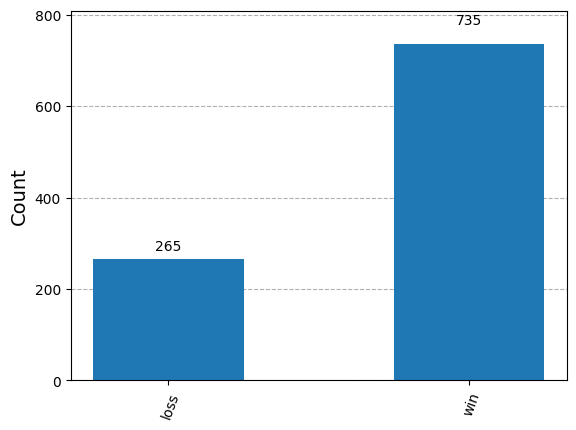

In [30]:
results = chsh_verifier(chsh_game_classical)
display(plot_histogram(results))

### Quantum

See if you can do better with a quantum strategy. What is the maximum win probability? Can you calculate it mathematically?

Hint: Alice and Bob can share a Bell pair and can measure in different bases.

In [31]:
def chsh_game_quantum(x, y):
    qc = QuantumCircuit(2)
    qc.initialize(Statevector([1,0,0,1]), normalize=True)
    if x == 1:
        qc.h(0)
    if y == 0:
        qc.ry(-np.pi/4, 1)
    else:
        qc.ry(np.pi/4, 1)
    qc.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    new_circuit = transpile(qc, backend)
    job = backend.run(new_circuit, shots = 1)
    results = job.result()
    counts = results.get_counts()
    a, b = next(iter(counts))
    return int(a), int(b)

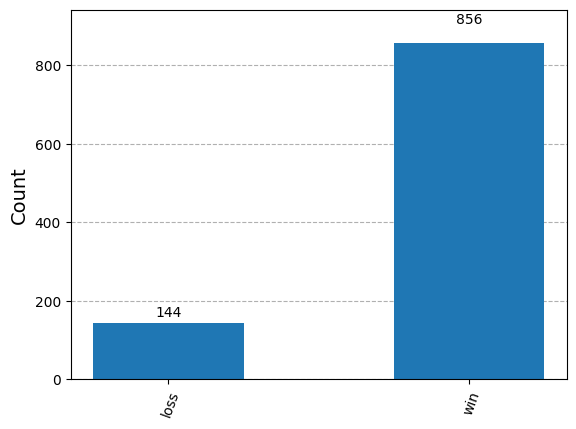

In [32]:
results = chsh_verifier(chsh_game_quantum)
display(plot_histogram(results))

# Deutsch-Jozsa Algorithm

Arguably the simplest "algorithm" in quantum computing is the Deutsch-Jozsa algorithm, which outperforms the best classical algorithm. The issue at hand is to determine whether a function is $f: \{0,1\}^n \rightarrow {0,1}$ is constant or balanced. In other words, $f$ takes as an input a length $n$ bitstring and outputs either 0 or 1 for each input. If $f$ is constant, it always outputs the same answer. If $f$ is balanced, then it outputs 0 for exactly half of the inputs and 1 for the other half.

Classically, the worst case scenario is we would need to check the output of $f$ for half of the number of bitsrings plus one. This is because, for example, if we measure half of the outputs to be 0, then we would need to measure one more input to be certain whether this $f$ is constant or balanced. So classically, worst case scenario, we need to make $2^{n-1} + 1$ queries of $f$. With the Deutsch-Jozsa algorithm on a quantum computer, however, we can always determine whether $f$ is constant or balanced in a *single query*!

For the Deutsch Jozsa algorithm, we need to translate $f$ to something a quantum computer can understand. So we encode $f$ into a unitary $U_f$ which acts on an $n+1$ qubit system (where $n$ is the length of the inputs to $f$). We do not count any extra gates needed for the circuit, such as $H$ gates, towards the number of queries –– only the number of times $U_f$ is applied.

### Understanding $U_f$

The role of $U_f$ is to apply the following action: $U_f \ket{x}\ket{y} = \ket{x}\ket{f(x) \oplus y} $, where $x$ is the n-bit input to $f$ and $y$ is a single qubit register. The operation $\oplus$ is addition mod 2. Here we will practice constructing $U_f$ for single bit input $x$.

**Example 1**

Here is an example which implements the constant $f$ which always outputs 0. The table summarizing for all possible bit combinations is here:

| $x$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $f(x)\oplus y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- |
 |0 | 0 | 0 | 0 |
 |0| 1 | 0 | 1 | 
 |1 | 0| 0 | 0 |
 |1| 1| 0 | 1 |

 And this can be implemented by the following circuit:

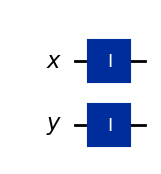

In [6]:
qx = QuantumRegister(1, 'x')
qy = QuantumRegister(1, 'y')
qc = QuantumCircuit(qx,qy)
qc.id(0)
qc.id(1)
display(qc.draw('mpl'))

**Example 2**

Here is an example which implements the following balanced $f$.

| $x$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $f(x)\oplus y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- |
 |0 | 0 | 0 | 0 |
 |0| 1 | 0 | 1 | 
 |1 | 0| 1 | 1 |
 |1| 1| 1 | 0 |

 And this can be implemented by the following circuit:

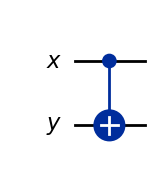

In [8]:
qx = QuantumRegister(1, 'x')
qy = QuantumRegister(1, 'y')
qc = QuantumCircuit(qx,qy)
qc.cx(0,1)
display(qc.draw('mpl'))

### Exercises

**A)** Fill in the table and create a circuit which implements $U_f$ for the following $f$:

| $x$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $f(x)\oplus y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- |
 |0 | 0 | 1 | 1 |
 |0| 1 | 1 | 0 | 
 |1 | 0| 1 | 1 |
 |1| 1| 1 | 0 |

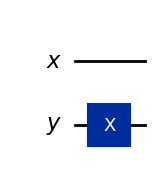

In [10]:
qx = QuantumRegister(1, 'x')
qy = QuantumRegister(1, 'y')
qc = QuantumCircuit(qx,qy)
qc.x(1)
display(qc.draw('mpl'))

**B)** Fill in the table and create a circuit which implements $U_f$ for the following $f$:

| $x$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |  $f(x)$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | $f(x)\oplus y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  |
| :-------------------------------- | :-------------------------------- | :-------------------------------- |:-------------------------------- |
 |0 | 0 | 1 | 1 |
 |0| 1 | 1 | 0 | 
 |1 | 0| 0 | 0 |
 |1| 1| 0 | 1 |

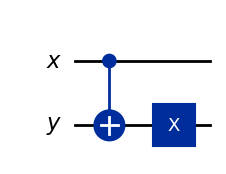

In [12]:
qx = QuantumRegister(1, 'x')
qy = QuantumRegister(1, 'y')
qc = QuantumCircuit(qx,qy)
qc.cx(0,1)
qc.x(1)
display(qc.draw('mpl'))

### The Algorithm

The Deutsch-Jozsa algorithm follows easily once $U_f$ is formed. First we prepare the helper qubit in $\ket{1}$. We simply apply H gates to all $n+1$ qubits ($n$ data qubit and 1 helper qubit, $y$), then apply $U_f$, then apply H gates to all n data qubits, and finally measure all n data qubits. If the measurement result is all zeros, i.e. $\ket{0}^{\otimes n}$, then $f$ is constant. Otherwise, $f$ is balanced.

**Exercise:** Let's test this out with our 1 bit examples. Plug in your $U_f$'s in the circuit below and see if it works as expected.

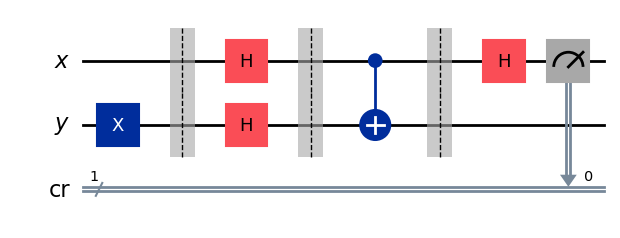

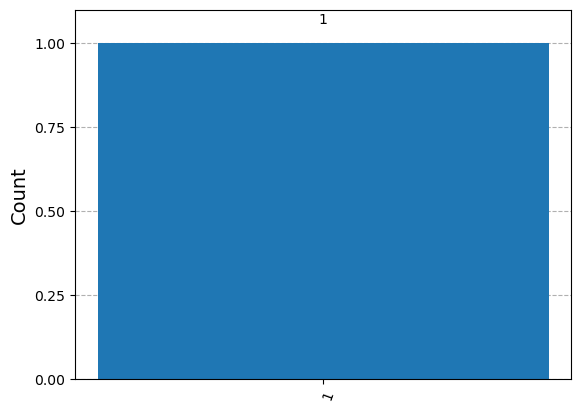

In [14]:
n=1
qx = QuantumRegister(n, 'x')
qy = QuantumRegister(1, 'y')
cr = ClassicalRegister(n,'cr')
qc = QuantumCircuit(qx,qy,cr)

# prepare y in the 1 state
qc.x(qy)
qc.barrier()
qc.h(qx)
qc.h(qy)
qc.barrier()

# insert U_f here
qc.cx(0,1)

qc.barrier()
qc.h(qx)

qc.measure(qx,cr)
display(qc.draw('mpl'))

backend = Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit, shots = 1) # we only need one query!
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

### Exercise

**A)** Find a $U_f$ which implements a constant $f$ for $n=2$.

**B)** Find a $U_f$ which implements a balanced $f$ for $n=2$.

**C)** Write code to test out the Deutsch-Jozsa algorithm for $n=2$. Do you get $\ket{00}$ for your $U_f$ from part a? What do you get for your $U_f$ from part b?

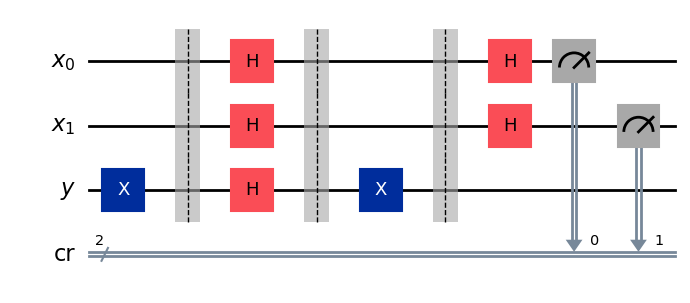

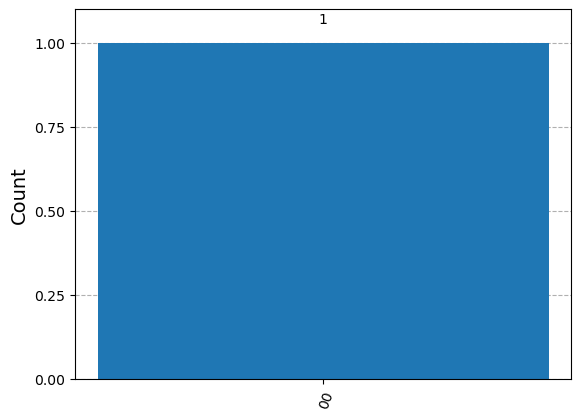

In [16]:
n=2
qx = QuantumRegister(n, 'x')
qy = QuantumRegister(1, 'y')
cr = ClassicalRegister(n,'cr')
qc = QuantumCircuit(qx,qy,cr)

# prepare y in the 1 state
qc.x(qy)
qc.barrier()
qc.h(qx)
qc.h(qy)
qc.barrier()

# insert U_f here
# f = 1
qc.x(qy)

qc.barrier()
qc.h(qx)

qc.measure(qx,cr)
display(qc.draw('mpl'))

backend = Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit, shots = 1) # we only need one query!
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

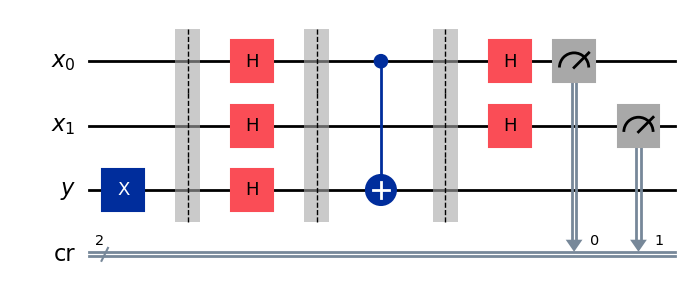

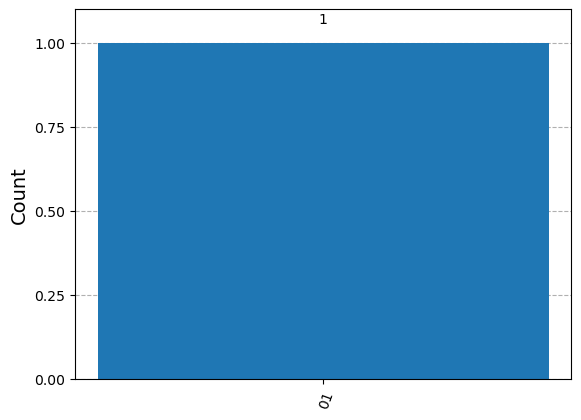

In [18]:
n=2
qx = QuantumRegister(n, 'x')
qy = QuantumRegister(1, 'y')
cr = ClassicalRegister(n,'cr')
qc = QuantumCircuit(qx,qy,cr)

# prepare y in the 1 state
qc.x(qy)
qc.barrier()
qc.h(qx)
qc.h(qy)
qc.barrier()

# insert U_f here
# f = 1 if x is even
qc.cx(0,qy)

qc.barrier()
qc.h(qx)

qc.measure(qx,cr)
display(qc.draw('mpl'))

backend = Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit, shots = 1) # we only need one query!
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

### How does it work?

Let's walk through why this algorithm works. We start in the state $\ket{\psi_0} = \ket{0}^{\otimes n} \otimes \ket{1}$. After applying the H gates, we have:

$$\begin{align}
\ket{\psi_1} &= H^{\otimes (n+1)} \ket{\psi_0} 
\end{align}$$

The state $\ket{+}^{\otimes n}$ is the equal superposition state of all bitstrings of length $n$. (Can you see why? Check for $n=2$.) So we can reexpress our state as:

$$\begin{align}
\ket{\psi_1} &= \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} \ket{x}\ket{-}
\end{align}$$

where we are summing over every bitstring of length n, i.e. every element of $\{0,1\}^n$. After we apply $U_f$ we get:

$$\begin{align}
\ket{\psi_2} &= U_f \ket{\psi_1} \\
&= \frac{1}{\sqrt{2^{n+1}}} \sum_{x\in\{0,1\}^n} \ket{x}(\ket{f(x)} - \ket{f(x)\oplus 1}) \\
&= \frac{1}{\sqrt{2^{n}}} \sum_{x\in\{0,1\}^n} (-1)^{f(x)}\ket{x}\ket{-}
\end{align}$$

**Bonus Exercise:** Can you convince yourself of the jump to the last line? In other words, show that: $\frac{1}{\sqrt{2}}(\ket{f(x)} - \ket{f(x)\oplus 1}) = (-1)^{f(x)}\ket{-}$

For the above exercise, plug in $f(x)=0$ and $f(x)=1$:
$$\begin{align}
\frac{1}{\sqrt{2}}(\ket{f(x)} - \ket{f(x)\oplus 1}) &= \frac{1}{\sqrt{2}}(\ket{0} - \ket{0\oplus 1}) \\
&= \frac{1}{\sqrt{2}}(\ket{0} - \ket{1}) \\
&= (-1)^{0}\ket{-} \\
&= (-1)^{f(x)}\ket{-} \\
\end{align}$$

$$\begin{align}
\frac{1}{\sqrt{2}}(\ket{f(x)} - \ket{f(x)\oplus 1}) &= \frac{1}{\sqrt{2}}(\ket{1} - \ket{1\oplus 1}) \\
&= \frac{1}{\sqrt{2}}(\ket{1} - \ket{0}) \\
&= (-1)^{1}\ket{-} \\
&= (-1)^{f(x)}\ket{-} 
\end{align}$$


Finally, we apply a Hadamard gate to our n data qubits:

$$\begin{align}
\ket{\psi_3} &= H^{\otimes n}\otimes I \ket{\psi_2} \\
&= \frac{1}{\sqrt{2^{n}}} \sum_{x\in\{0,1\}^n} (-1)^{f(x)} \bigg( \sum_{z\in\{0,1\}^n} (-1)^{x\cdot z} \ket{z} \bigg) \ket{-} \\
&= \frac{1}{2^{n}} \sum_{z\in\{0,1\}^n} \sum_{x\in\{0,1\}^n} (-1)^{f(x)+ x\cdot z} \ket{z} \ket{-}
\end{align}$$

where $x\cdot z = x_1 z_1 + \dots + x_n z_n$.

Now we just need to draw our conclusion.

**Exercise:** Compute the amplitude on the state $\ket{z} = \ket{0}^{\otimes n}$ in the two cases. Case 1 is $f$ is constant and Case $2$ is $f$ is balanced. In other words, compute $$\frac{1}{2^{n}} \sum_{x\in\{0,1\}^n} (-1)^{f(x)+ x\cdot z} $$ for $z = 00\cdots 0$. 

*Hint: just by calculating this, you do not need to consider the probability amplitude of other states. Distinguishing between constant and balanced depends only on the amplitude of this state.*

For the above exercise, you should find that the probability amplitude in front of $\ket{z} = \ket{0}^{\otimes n}$ is 1 for a constant $f$ and 0 for a balanced $f$. From this we know that if we measure $000\cdots 0$, we have a constant $f$, and if we measure anything else, we have a balanced $f$.

# Grover's Algorithm

# Implementing Grover's Algorithm

In lecture, you learned a bit about Grover's algorithm. Maybe it made sense to you, or maybe you found it confusing... Either way, playing around with Grover's algorithm in Qiskit can help us feel more comfortable with the ideas behind Grover's algorithm, what it does, and why it works!

Let's say we have a black box which takes in an N-bit input and returns "Success" for one input bit string and "Failure" for all the others. We want to find out what the "success" input bit-string is in the least number of querys to the black box.

To put this a bit more mathematically, the problem is as follows. The black box acts as a function $f(x): \{0,1,\dots, N\} \rightarrow \{0,1\}$, where $f(x)=1$ if and only if $x$ is the "success" input and $f(x)=0$ otherwise.

Classically, the best we can do is just try all the bit strings until we get "Success." On average, we will need to test half of the bit strings to find the right one. So classically, we need $O(N)$ evaluations of the black box.

Grover's search algorithm can accomplish this in $O(\sqrt{N})$ evaluations of the black box (which is often called the "oracle"). [Note: if we have n qubits, we have $N=2^n$ classical bits of information.] The big picture overview of how this is possible is because with quantum superposition, we can test all bit strings at once. Let's get into the details.

The "black box" or "oracle" for Grover's search ($\mathcal{S}_f$) is a phase-flip oracle. It flips the phase of _only_ the "success" bitstring. So the action of $\mathcal{S}_f$ is:

$$|x\rangle \rightarrow (-1)^{f(x)} |x\rangle$$

In other words, $|x\rangle \rightarrow -|x\rangle$ if and only if $x$ is the right input.

If we start with $n$ qubits in the $|0\rangle$ state and apply a Hadamard to each one, then we will be in the equal superposition state of every bitstring of length $n$ (of which there are $N=2^n$). We can easily see this with 2 qubits:

$$H|0\rangle \otimes H|0\rangle = \frac{1}{2} \big[ (|0\rangle + |1\rangle) \otimes (|0\rangle + |1\rangle) \big] = \frac{1}{2} \big[ |00\rangle + |01\rangle + |10\rangle + |11\rangle \big]$$

At the start of the protocol, we create the following state:

<div>
<img src="figures/entanglement/grover_1.png" width="500"/>
</div>

So we can send this state into the oracle $\mathcal{S}_f$, and we will get the same state with the phase of the right bitstring flipped.

We can visualize this step as follows:

<div>
<img src="figures/entanglement/grover_2.png" width="500"/>
</div>

Note that the overall amplitude of the states has been reduced from $1/\sqrt{N}$ to something smaller. The exact amount can be computed, but is not important for the purposes of this tutorial.

The second step of Grover's algorithm is called amplitude amplification. In this step, we flip every state's amplitude about the overall average amplitude of all states. Every state with a positive amplitude will get a smaller amplitude, and the "right input" state will get a much larger positive amplitude. We can visualize this step as follows:

<div>
<img src="figures/entanglement/grover_3.png" width="500"/>
</div>

In practice, we implement this amplitude amplification by applying a "diffusion operator" defined as:

$$ \mathcal{D} = H^{\otimes n} \mathcal{S}_0 H^{\otimes n}$$

where $\mathcal{S}_0$ is the zero reflection operator:

$$\mathcal{S}_0 = 2 |0\rangle^{\otimes n} \langle 0|^{\otimes n} - \mathbb{I}_n$$

All that remains is applying these steps multiple times until we have reached an optimal number of iterations (at some point there would be diminishing returns where the wrong states amplitudes begin to grow again). Finally we perform a measurement and we should get our target state with very high probability.

The reason Grover's search is $O(\sqrt{N})$ is because the optimal number of iterations is $O(\sqrt{N})$.

Now that we have a sense of what Grover's algorithm does and why it works, let's play around with it in Qiskit.


Note: The following code is adpated from IBM's documentation: https://learning.quantum.ibm.com/tutorial/grovers-algorithm.

### Creating a phase-flip oracle

First things first, let's understand how a phase-flip oracle is made. Let's start by preparing an equal superposition state by applying a Hadamard to each qubit. Then let's build a phase-flip oracle step-by-step.

Consider a two-qubit system with target state '01'.

In [40]:
target_state = '01'

num_qubits = len(target_state)

We first apply an X gate to the location of any zeros in our target state. We will still have an equal superposition state after this.

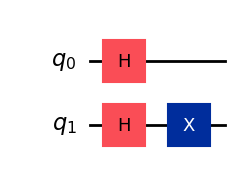

In [41]:
qc = QuantumCircuit(num_qubits)

# apply Hadamard to all qubits to be in complete superposition state
qc.h(range(num_qubits))

# Flip target bit-string to match Qiskit bit-ordering
rev_target = target_state[::-1]

# Find the indices of all the '0' elements in bit-string
zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]

if len(zero_inds) > 0:
    qc.x(zero_inds)

qc.draw('mpl')

We can print out the state vector at the end of the circuit to see what is going on.

In [42]:
display(Statevector(qc).draw('latex'))

<IPython.core.display.Latex object>

Now, let's add a multi-controlled Z gate, which is controlled on the first $n-1$ qubits and targeted on the last qubit. The effect of this is it flips the phase of any state with all 1's. This is because we need all 1's in the first $n-1$ qubit for the control condition to be satisfied, and we need the last qubit to be 1 for the Z gate to have a phase flip effect.

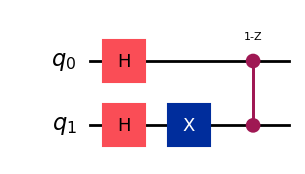

In [43]:
qc = QuantumCircuit(num_qubits)

# apply Hadamard to all qubits to be in complete superposition state
qc.h(range(num_qubits))

# Flip target bit-string to match Qiskit bit-ordering
rev_target = target_state[::-1]

# Find the indices of all the '0' elements in bit-string
zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]

if len(zero_inds) > 0:
    qc.x(zero_inds)
qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)

qc.draw('mpl')

In [44]:
display(Statevector(qc).draw('latex'))

<IPython.core.display.Latex object>

We can see that the $|11\rangle$ state has been phase flipped, as expected.

Now we can apply X gates again to any location of 0 in the target state. This ensures the phase flip is moved back to the target state (instead of staying on $|11\rangle$).

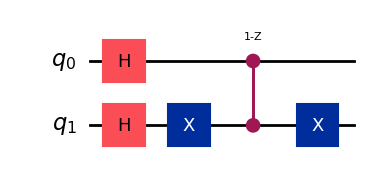

In [45]:
qc = QuantumCircuit(num_qubits)

# apply Hadamard to all qubits to be in complete superposition state
qc.h(range(num_qubits))

# Flip target bit-string to match Qiskit bit-ordering
rev_target = target_state[::-1]

# Find the indices of all the '0' elements in bit-string
zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]

if len(zero_inds) > 0:
    qc.x(zero_inds)
qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
if len(zero_inds) > 0:
    qc.x(zero_inds)

qc.draw('mpl')

In [46]:
display(Statevector(qc).draw('latex'))

<IPython.core.display.Latex object>

Ok, great, it works! We got a phase flip on just our target state. So we have successfully built a phase-flip oracle for two qubits.

### Exercise 

**A)** Following the same approach as above, construct an oracle for the target state 00.

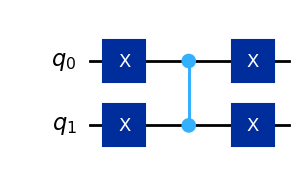

In [47]:
qc = QuantumCircuit(2)
qc.x(0)
qc.x(1)
qc.cz(0,1)
qc.x(0)
qc.x(1)
display(qc.draw('mpl'))

**B)** Following the same approach as above, but for a 3 qubit system, construct an oracle for the target state 011.

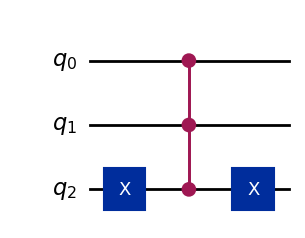

In [48]:
qc = QuantumCircuit(3)
qc.x(2)
qc.ccz(0,1,2)
qc.x(2)
display(qc.draw('mpl'))

### The Full Algorithm

Now let's see the full algorithm in action. First we can define the Grover phase-flip oracle. It takes "marked_states" (a.k.a. target states) as input and outputs the correct phase-flip oracle based on the technique we showed above. This is a more general oracle, because you can input more than one target state if you want. It just repeats the phase-flip algorithm above for each target state.

In [49]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:

        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]

        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]

        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        # MCMT stands for Multi-Control, Multi-Target. The 1st argument is the type of gate,
        # the 2nd argument is the number of control qubits, and the 3rd is the number of target qubits
        if len(zero_inds) > 0:
            qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        if len(zero_inds) > 0:
            qc.x(zero_inds)
        qc.barrier()

    return qc

Let's see the Grover oracle in action for 3 qubits and two marked states.

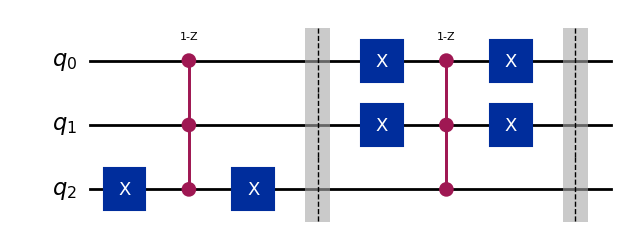

In [50]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw('mpl')

We can use Qiskit's built in Grover operator algorithm to do the rest. It takes the oracle we have defined above as input, and implements the amplitude amplificiation protocol described earlier.

Note: Documentation for the GroverOperator class: https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.GroverOperator

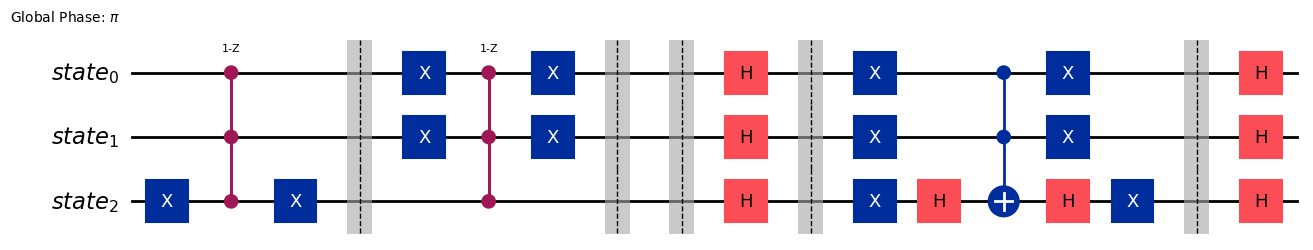

In [51]:
grover_op = GroverOperator(oracle, insert_barriers=True)
grover_op.decompose().draw('mpl')

The optimal number of iterations is given by: $ \frac{\pi}{4} \sqrt{ \frac{2^{n}}{m} } $ where $n$ is the number of qubits and $m$ is the number of marked states. Recall that there are $N=2^n$ bit strings of length $n$, so the optimal number of iterations is $O(\sqrt{N})$. We round the result down to the nearest integer. (See the textbook by Kaye, Laflamme & Mosca if you're curious for more details on this.)

In [52]:
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**grover_op.num_qubits / len(marked_states))
)
optimal_num_iterations

1

Finally, we can run our Grover's search algorithm! We create a quantum circuit with the right number of qubits, create an equal superposition state with Hadamard gates, apply the entire Grover circuit for the optimal number of iterations, and then measure all the qubits.

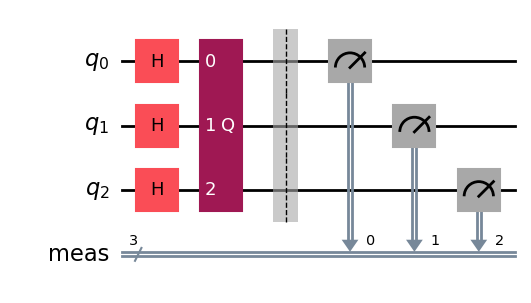

In [53]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw('mpl')

Let's simulate our circuit for 1000 shots and see what states we get.

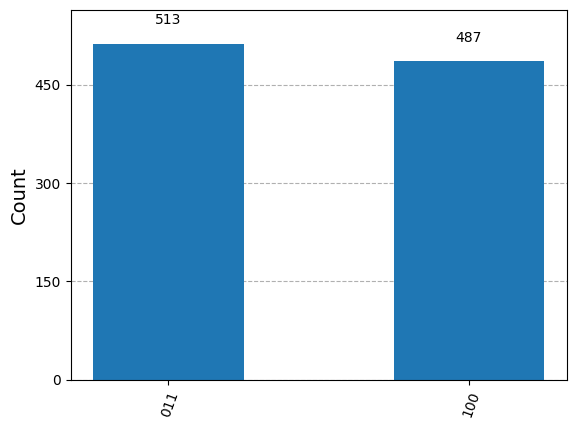

In [54]:
backend=Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit, shots = 1000)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

### Play Around with Grover's Algorithm

Some things to try:

- Add more qubits. You can do this by changing the number of bits in "marked_states"
- Force the number of iterations to be something else. What happens to the final distribution of states?